In [4]:
import statsmodels.formula.api as smf
import utils.database as db
import utils.model_evaluation as me

# Evaluating bias under model with higher explanatory power

Prior findings showed correlations between racial and political characteristics of a county and the amount of Paycheck Protection Program funds received, but with [relatively low explanatory power](project_regression_analysis.ipynb) (Adj. R^2 = 0.235). 

The goal of this continued research is to see whether these trends persist after adding further economic controls. Specifically, whether county-level industry composition has an impact on distribution of PPP funds. This is an important control as customer-facing industries like restaurants and entertainment were suddenly and immediately shut down in March 2020. Concentration of these customer-facing industries, in particular, are likely an important control for racial and political characteristics (measured as Republican vote share). 

In [5]:
query = """
    SELECT * EXCLUDE (ppp_loan_amount, total_annual_wages)
    FROM gold.wage_adjusted_ppp_target
"""
df = db.query_df(query)

df_clean = df.dropna()
assert len(df) == len(df_clean), 'Design matrix has missing values to remove'
del df_clean
df.head()

county     state urbanicity  yoy_job_change_pct  \
0  Appomattox County  Virginia      urban           -0.016036   
1   Arlington County  Virginia      urban            0.026394   
2       Giles County  Virginia      urban           -0.025776   
3     Grayson County  Virginia      rural            0.121393   
4    Richmond County  Virginia      rural           -0.001100   

   wage_adjusted_ppp_loan_amount  white_pop_share  black_pop_share  \
0                       0.172092         0.786940         0.185469   
1                       0.059148         0.750032         0.096782   
2                       0.069858         0.962739         0.015969   
3                       0.160522         0.924823         0.057428   
4                       0.170235         0.667516         0.296465   

   asian_pop_share  native_pop_share  hispanic_share  ...  \
0         0.003834          0.003520        0.018855  ...   
1         0.109546          0.007769        0.156015  ...   
2         0.005801          0.002990        0.018361  ...   
3         0.002058          0.003601        0.038264  ...   
4         0.007093          0.006096        0.072925  ...   

   retail_trade_wage_share  retail_trade_job_loc_quotient  \
0                 0.225276                           1.94   
1                 0.024007                           0.49   
2                 0.103267                           1.30   
3                 0.057088                           0.51   
4                 0.074205                           0.79   

   transportation_and_warehousing_wage_share  \
0                                   0.000000   
1                                   0.064589   
2                                   0.019956   
3                                   0.015953   
4                                   0.000000   

   transportation_and_warehousing_job_loc_quotient  unclassified_wage_share  \
0                                             0.00                 0.003127   
1                                             1.40                 0.001434   
2                                             0.41                 0.001315   
3                                             0.23                 0.000000   
4                                             0.00                 0.000000   

   unclassified_job_loc_quotient  utilities_wage_share  \
0                           2.79              0.000000   
1                           1.60              0.011543   
2                           1.50              0.000000   
3                           0.00              0.000000   
4                           0.00              0.000000   

   utilities_job_loc_quotient  wholesale_trade_wage_share  \
0                        0.00                    0.036170   
1                        0.53                    0.017317   
2                        0.00                    0.000000   
3                        0.00                    0.000000   
4                        0.00                    0.074327   

   wholesale_trade_job_loc_quotient  
0                              0.47  
1                              0.22  
2                              0.00  
3                              0.00  
4                              1.13  

[5 rows x 51 columns]

## Evaluate correlations of numerical variables

Exclude all location quotient information for direct covariance with wage share. Keep wage share to prefer trends in local economic makeup, rather than relation to national economy indicated by loc quotient. 

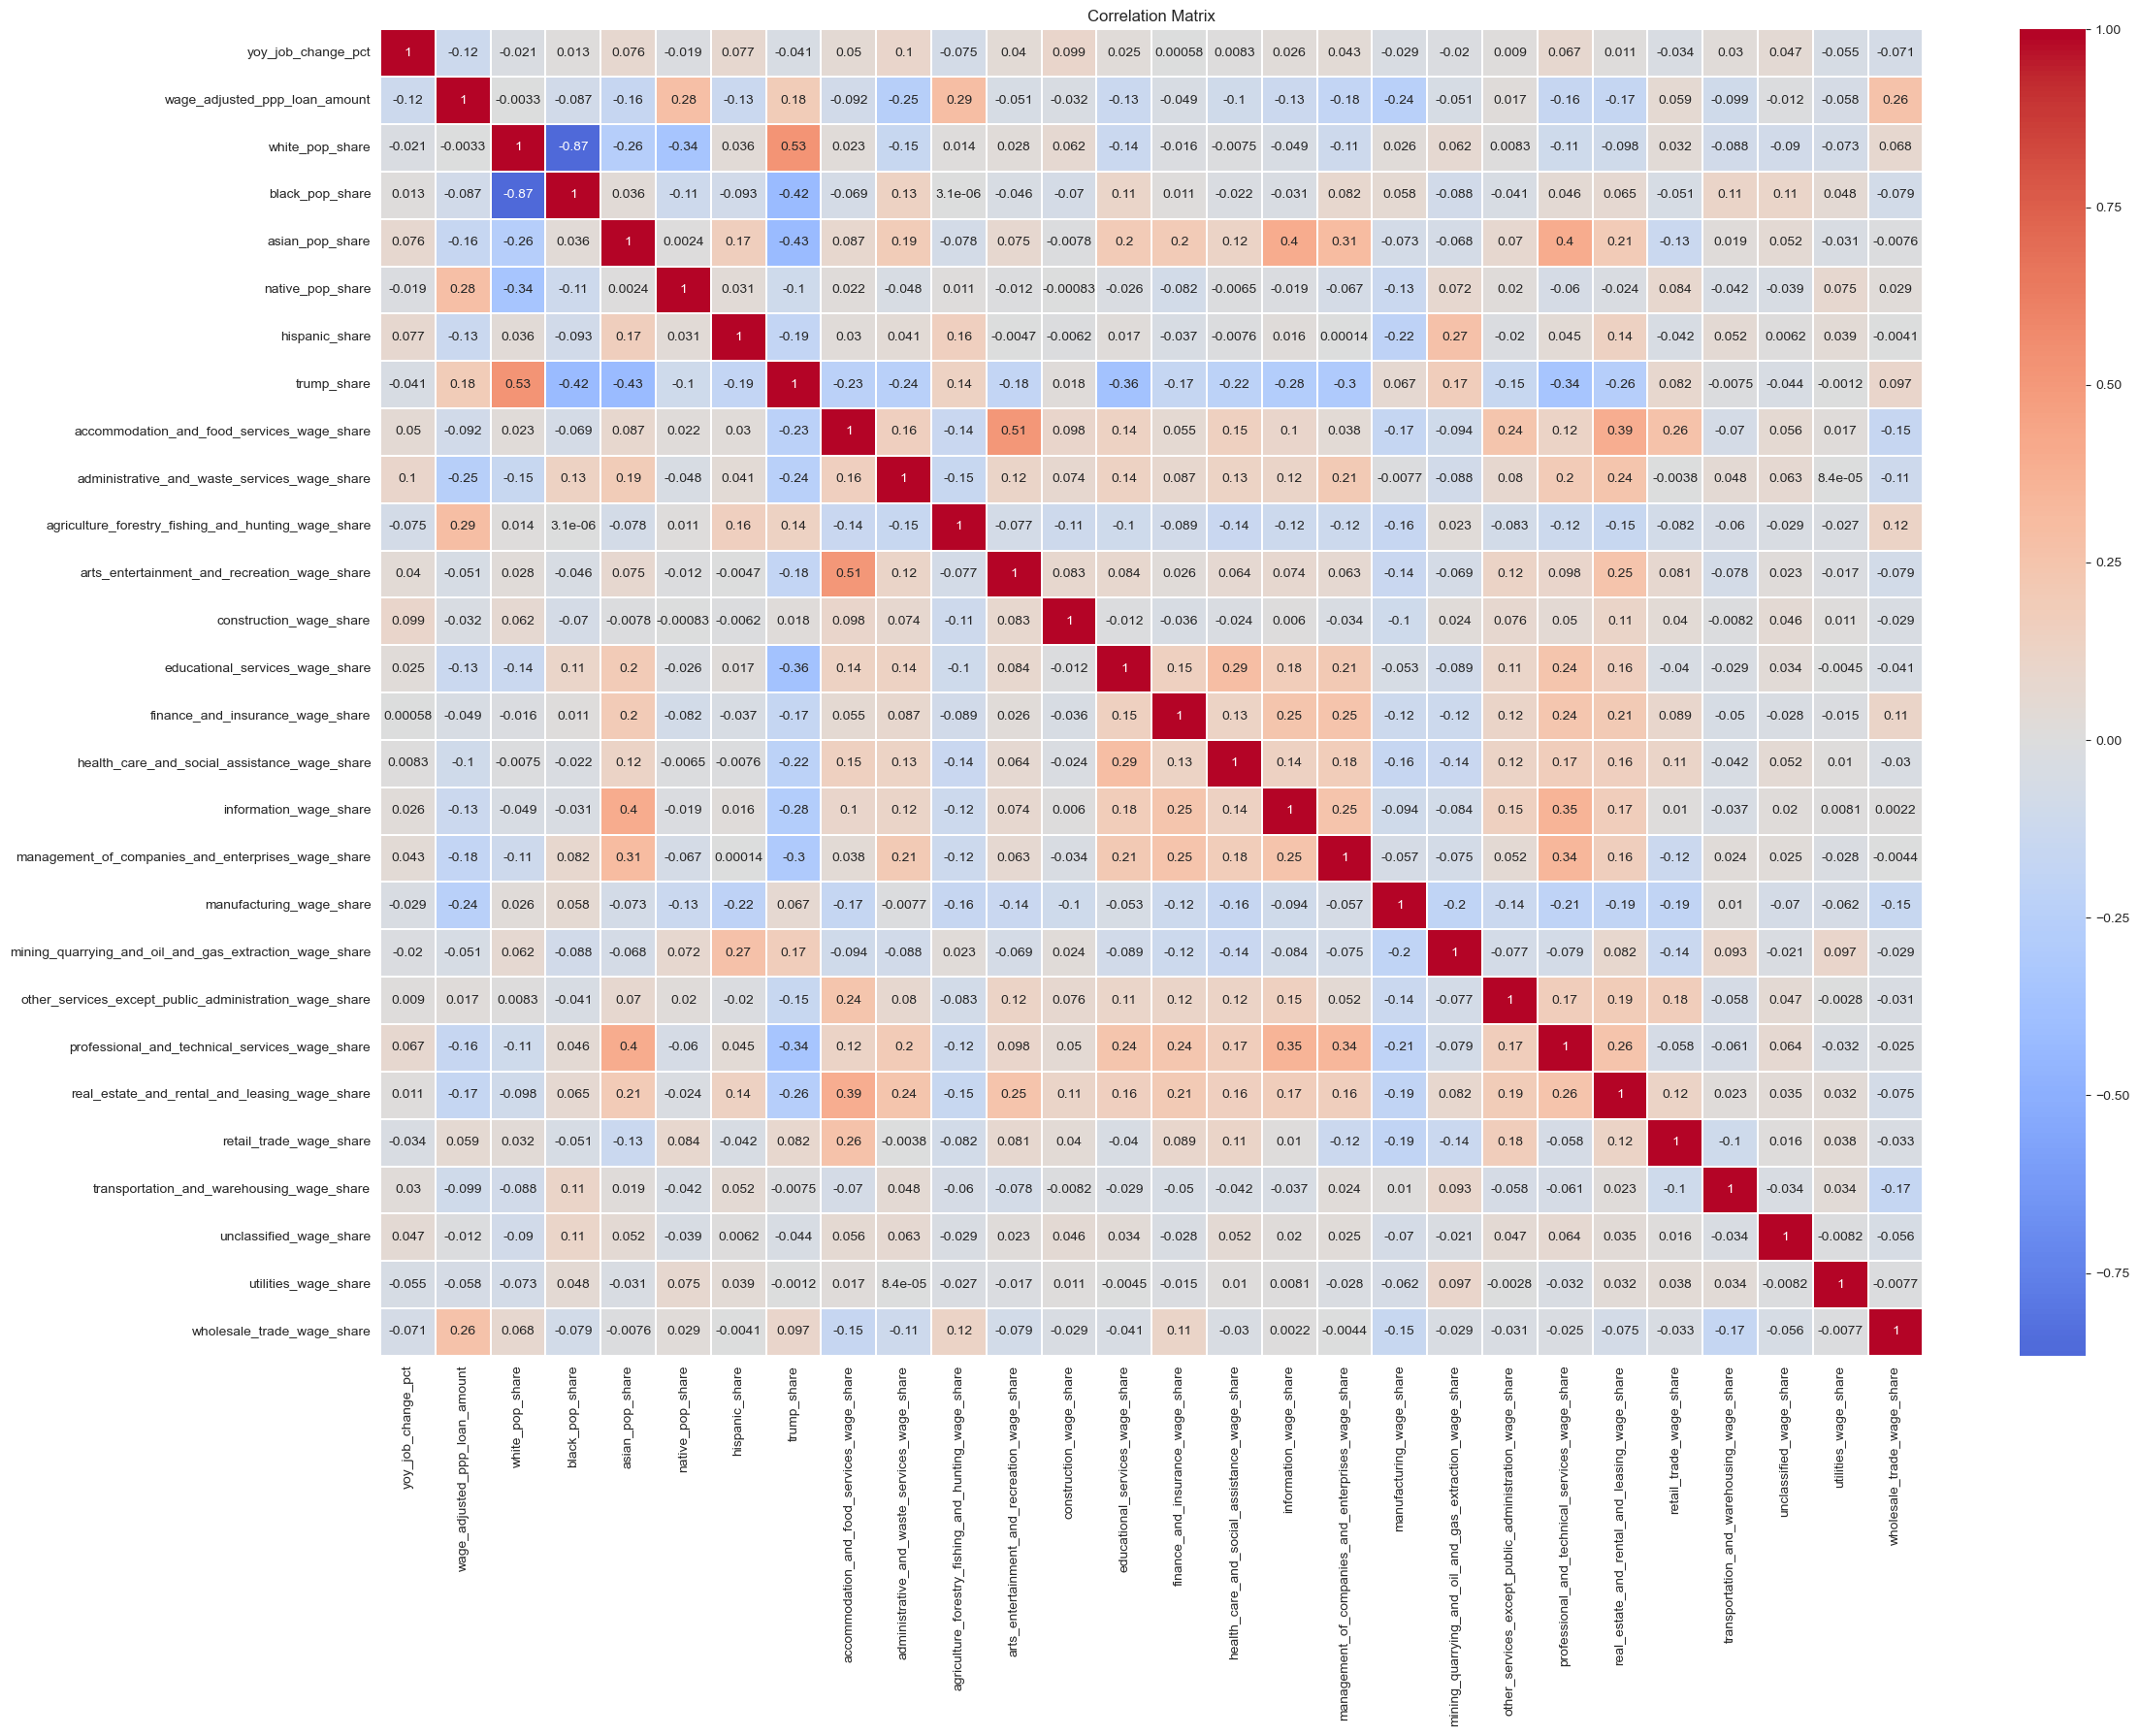

In [6]:
fig_size = (24, 18)
no_loc_df = df[[c for c in df.columns if '_loc_' not in c]]
me.plot_correlation_matrix(data=no_loc_df, fig_size=fig_size, annot=True)

## Evaluate multi-collinearity for regression on all features

Evaluate regression against full model. 

In [7]:
target = 'wage_adjusted_ppp_loan_amount'

base_model_spec = {
    'target': f'np.log({target})',
    'data': no_loc_df,
    'exclusion_set': None,
    'cat_var_set': {"C(urbanicity, Treatment(reference='urban'))"}
}

base_model_formula = me.generate_formula_string(**base_model_spec)
base_model = smf.ols(base_model_formula, data=df).fit()

me.evaluate_vifs(base_model)

Feature          VIF
0                                           Intercept  7461.298019
28                                    white_pop_share   193.093674
8                                     black_pop_share   160.564823
18                                   native_pop_share    39.166912
7                                     asian_pop_share    11.367546
24                                        trump_share     2.355496
1   C(urbanicity, Treatment(reference='urban'))[T....     2.017849
3          accommodation_and_food_services_wage_share     1.755223
16                           manufacturing_wage_share     1.710970
27                      wage_adjusted_ppp_loan_amount     1.660225
2   C(urbanicity, Treatment(reference='urban'))[T....     1.602512
20     professional_and_technical_services_wage_share     1.551402
21      real_estate_and_rental_and_leasing_wage_share     1.455001
13                                     hispanic_share     1.410527
6        arts_entertainment_and_recreation_wage_share     1.408209
17  mining_quarrying_and_oil_and_gas_extraction_wa...     1.373628
14                             information_wage_share     1.346594
15  management_of_companies_and_enterprises_wage_s...     1.341358
22                            retail_trade_wage_share     1.334801
5   agriculture_forestry_fishing_and_hunting_wage_...     1.276946
10                    educational_services_wage_share     1.261654
12       health_care_and_social_assistance_wage_share     1.252875
11                   finance_and_insurance_wage_share     1.246057
4        administrative_and_waste_services_wage_share     1.227245
29                         wholesale_trade_wage_share     1.193298
19  other_services_except_public_administration_wa...     1.155161
9                             construction_wage_share     1.110360
23          transportation_and_warehousing_wage_share     1.107460
30                                 yoy_job_change_pct     1.057863
26                               utilities_wage_share     1.048052
25                            unclassified_wage_share     1.044356

# Address multi-collinearity

Remove specific demographic variables to reduce multi-collinearity in demographic and political variables. Start by removing white share, seeing covariance matrix trend between white population and Trump share and stronger correlation between target and black population share.  

In [37]:
m_col_model_spec = {
    'target': f'np.log({target})',
    'data': no_loc_df,
    'exclusion_set': {'white_pop_share'},
    'cat_var_set': {"C(urbanicity, Treatment(reference='urban'))"}
}

m_col_formula = me.generate_formula_string(**m_col_model_spec)
m_col_model = smf.ols(m_col_formula, data=df).fit()

me.evaluate_vifs(m_col_model)

Feature        VIF
0                                           Intercept  92.908603
24                                        trump_share   2.353105
1   C(urbanicity, Treatment(reference='urban'))[T....   2.011813
3          accommodation_and_food_services_wage_share   1.737550
16                           manufacturing_wage_share   1.702035
27                      wage_adjusted_ppp_loan_amount   1.649255
2   C(urbanicity, Treatment(reference='urban'))[T....   1.599058
8                                     black_pop_share   1.575150
7                                     asian_pop_share   1.562858
20     professional_and_technical_services_wage_share   1.551351
21      real_estate_and_rental_and_leasing_wage_share   1.454881
6        arts_entertainment_and_recreation_wage_share   1.405570
13                                     hispanic_share   1.404382
17  mining_quarrying_and_oil_and_gas_extraction_wa...   1.373065
14                             information_wage_share   1.342265
15  management_of_companies_and_enterprises_wage_s...   1.339372
22                            retail_trade_wage_share   1.333124
5   agriculture_forestry_fishing_and_hunting_wage_...   1.276036
10                    educational_services_wage_share   1.261497
12       health_care_and_social_assistance_wage_share   1.252634
11                   finance_and_insurance_wage_share   1.244578
18                                   native_pop_share   1.241060
4        administrative_and_waste_services_wage_share   1.226515
28                         wholesale_trade_wage_share   1.189163
19  other_services_except_public_administration_wa...   1.154789
9                             construction_wage_share   1.110208
23          transportation_and_warehousing_wage_share   1.107371
29                                 yoy_job_change_pct   1.057698
26                               utilities_wage_share   1.047179
25                            unclassified_wage_share   1.044139

## Multi-collinear adjustment results

Removing white vote share addressed multi-collinearity sufficiently to proceed with control model analysis of demographic trends against industry totals. 

bp_stat: 530.8033624136503 | bp_pvalue: 1.3162165747997838e-93


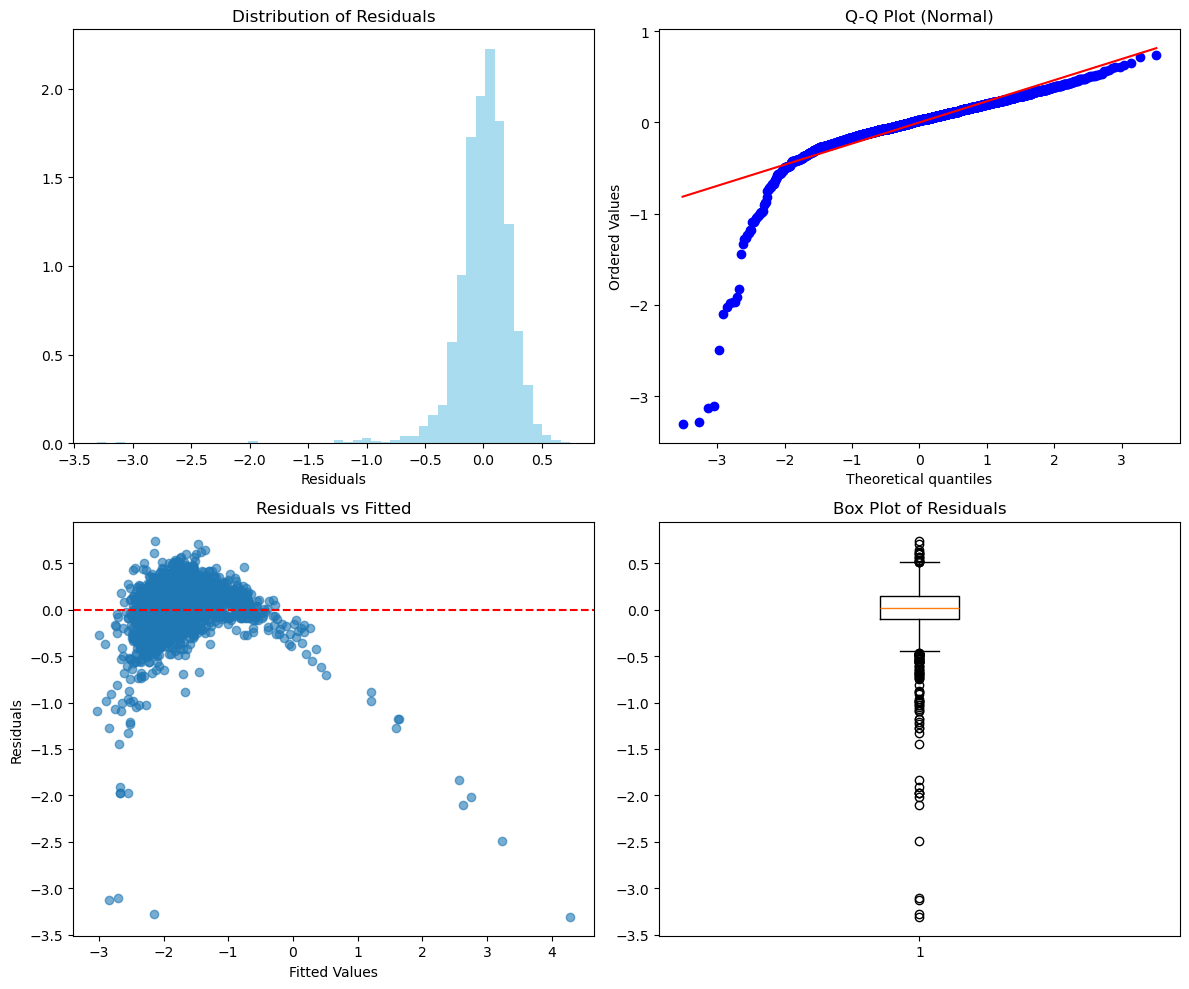

In [38]:
me.test_model_assumptions(m_col_model)

## Model shows strong heteroscedacity

Violates assumption of normally distributed residuals, making p-values unreliable. Investigating robust standard errors for improvements.

Evaluate model with individual variables to assess features with most heteroscedastic residuals. 

In [52]:
base_model.model.endog_names

'np.log(wage_adjusted_ppp_loan_amount)'

Heteroscedacity evaluation for accommodation_and_food_services_wage_share
bp_stat: 61.21154140599513 | bp_pvalue: 5.126015259461992e-15


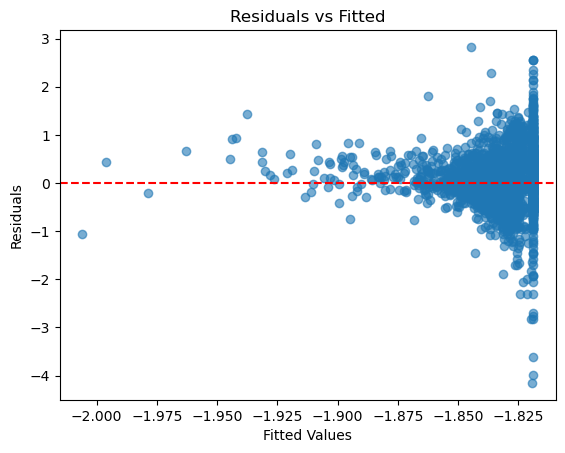

Heteroscedacity evaluation for administrative_and_waste_services_wage_share
bp_stat: 23.39054310298559 | bp_pvalue: 1.3222698731755598e-06


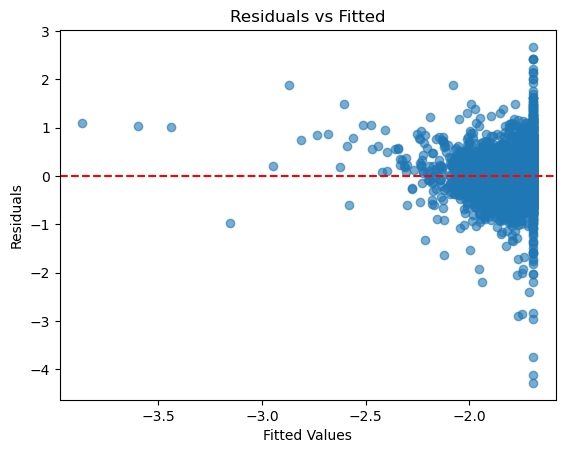

Heteroscedacity evaluation for agriculture_forestry_fishing_and_hunting_wage_share
bp_stat: 8.551527319778664 | bp_pvalue: 0.003452324504495668


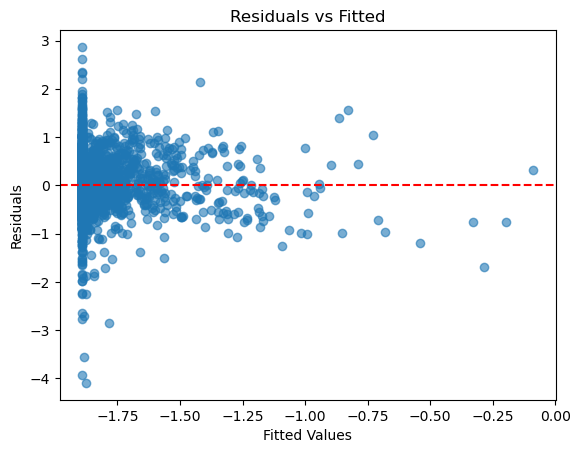

Heteroscedacity evaluation for arts_entertainment_and_recreation_wage_share
bp_stat: 15.568181859578933 | bp_pvalue: 7.958261607495974e-05


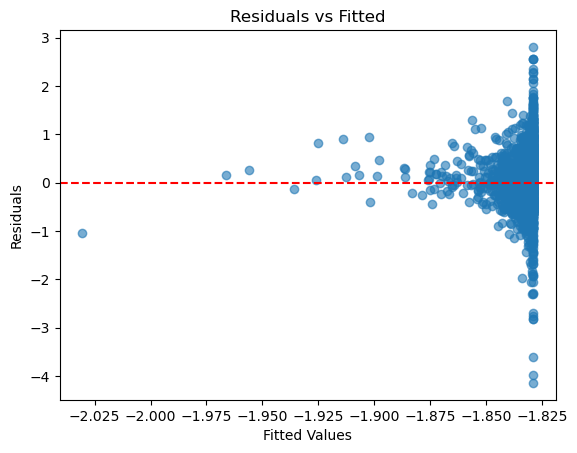

Heteroscedacity evaluation for asian_pop_share
bp_stat: 1.5445742827167088 | bp_pvalue: 0.21393821451944317


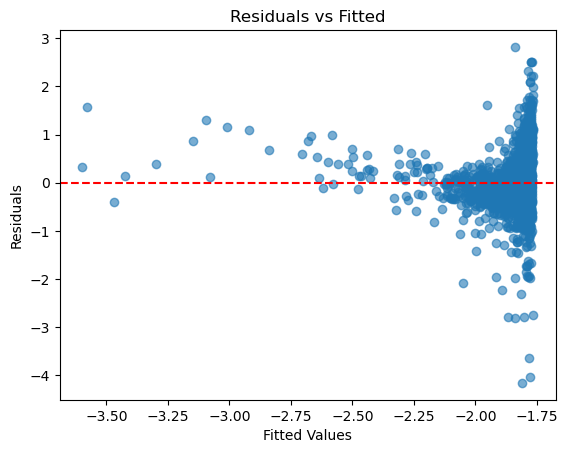

Heteroscedacity evaluation for black_pop_share
bp_stat: 6.124842294916625 | bp_pvalue: 0.013329517818940387


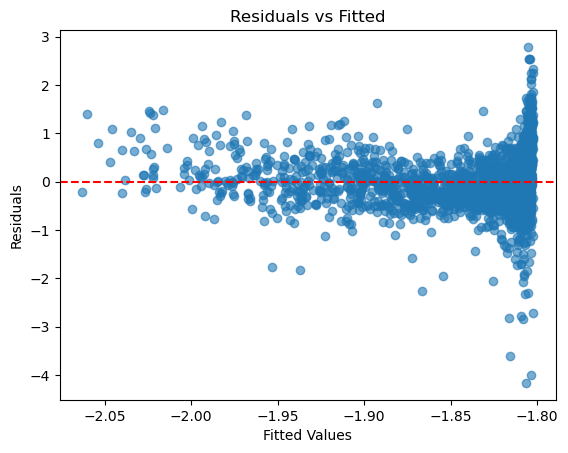

Heteroscedacity evaluation for construction_wage_share
bp_stat: 11.427776295305355 | bp_pvalue: 0.0007235422909087202


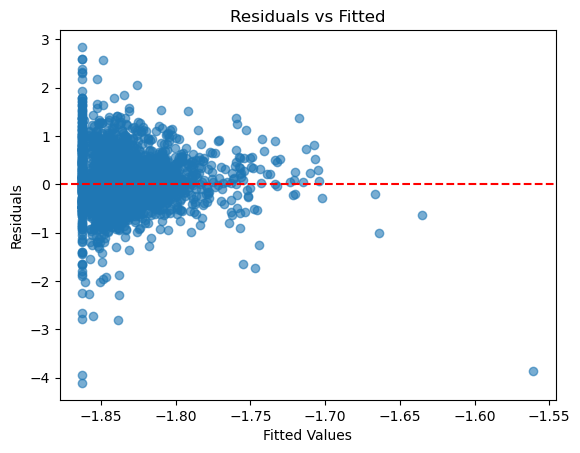

Heteroscedacity evaluation for educational_services_wage_share
bp_stat: 12.84986968627161 | bp_pvalue: 0.0003375027466823753


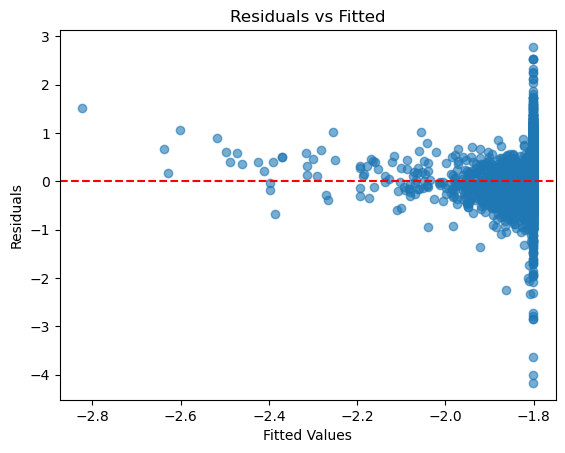

Heteroscedacity evaluation for finance_and_insurance_wage_share
bp_stat: 29.230391191680777 | bp_pvalue: 6.426328736921689e-08


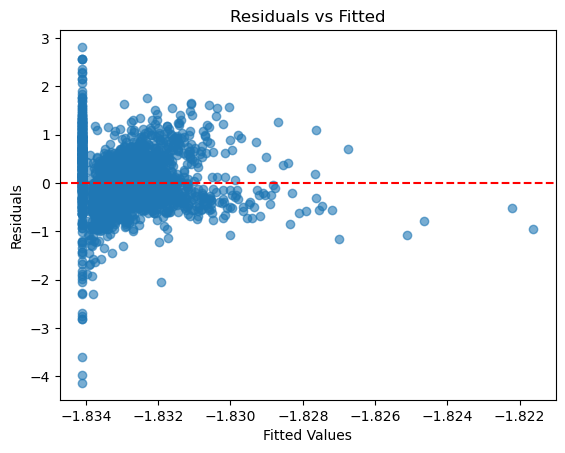

Heteroscedacity evaluation for health_care_and_social_assistance_wage_share
bp_stat: 42.61403800488921 | bp_pvalue: 6.667912224200198e-11


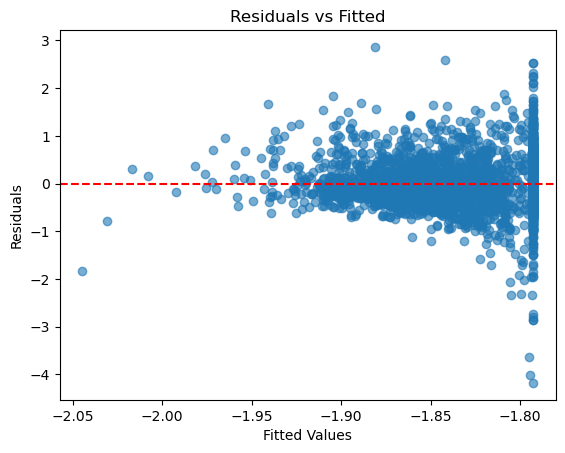

Heteroscedacity evaluation for hispanic_share
bp_stat: 1.5593533959060435 | bp_pvalue: 0.2117599206529667


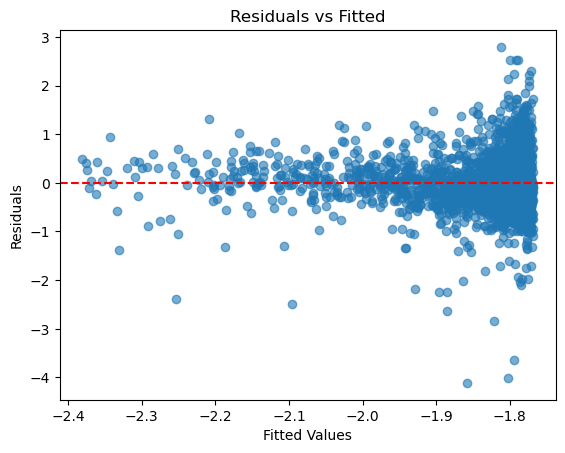

Heteroscedacity evaluation for information_wage_share
bp_stat: 30.12964077747902 | bp_pvalue: 4.041073012597088e-08


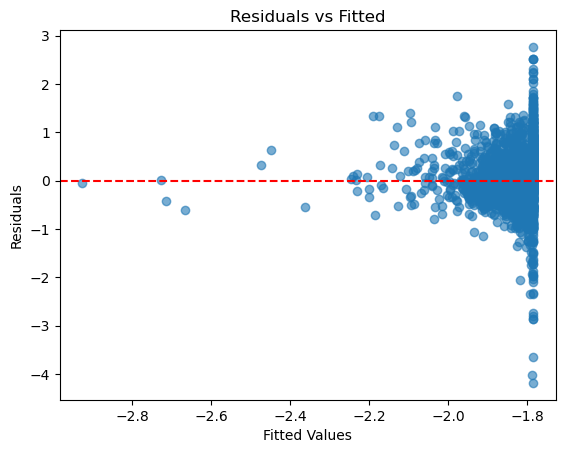

Heteroscedacity evaluation for management_of_companies_and_enterprises_wage_share
bp_stat: 20.703246470138108 | bp_pvalue: 5.362500649020002e-06


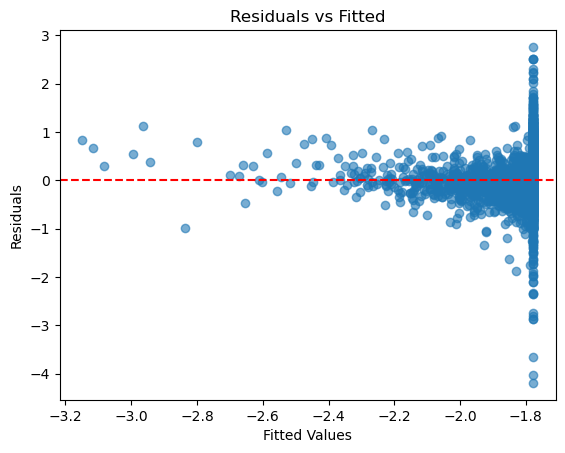

Heteroscedacity evaluation for manufacturing_wage_share
bp_stat: 71.74861010287003 | bp_pvalue: 2.4443606298353615e-17


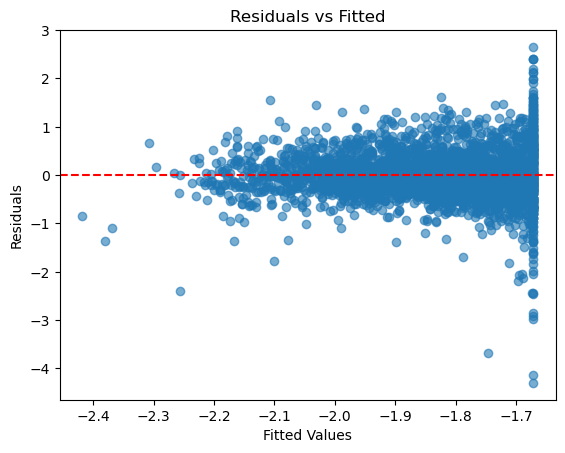

Heteroscedacity evaluation for mining_quarrying_and_oil_and_gas_extraction_wage_share
bp_stat: 11.979730590843388 | bp_pvalue: 0.0005378235898797284


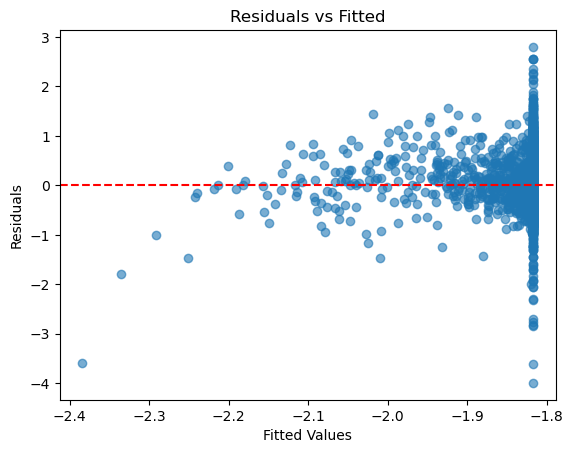

Heteroscedacity evaluation for native_pop_share
bp_stat: 14.466393246067787 | bp_pvalue: 0.00014268258253588586


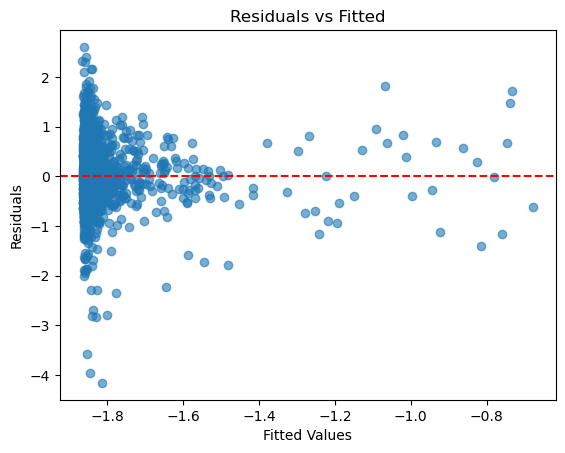

Heteroscedacity evaluation for other_services_except_public_administration_wage_share
bp_stat: 49.18948461246232 | bp_pvalue: 2.3239314181218476e-12


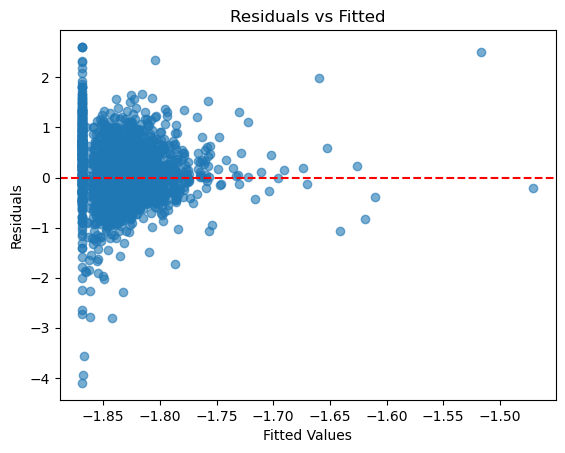

Heteroscedacity evaluation for professional_and_technical_services_wage_share
bp_stat: 33.21797044045808 | bp_pvalue: 8.238563513895986e-09


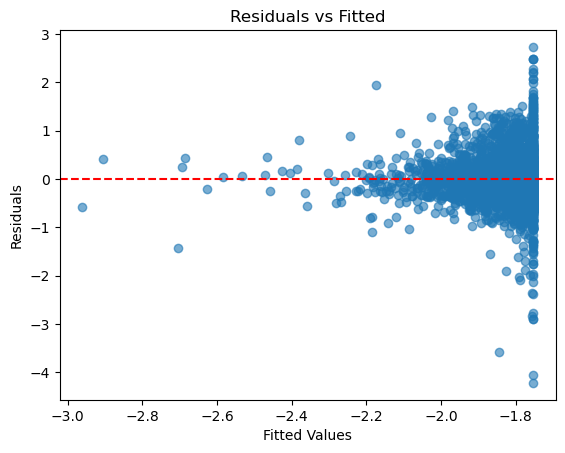

Heteroscedacity evaluation for real_estate_and_rental_and_leasing_wage_share
bp_stat: 48.21091436475761 | bp_pvalue: 3.827519660616326e-12


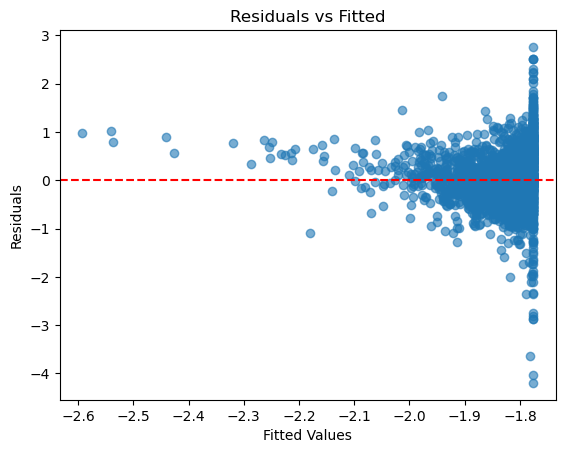

Heteroscedacity evaluation for retail_trade_wage_share
bp_stat: 169.9874754615141 | bp_pvalue: 7.445638941865658e-39


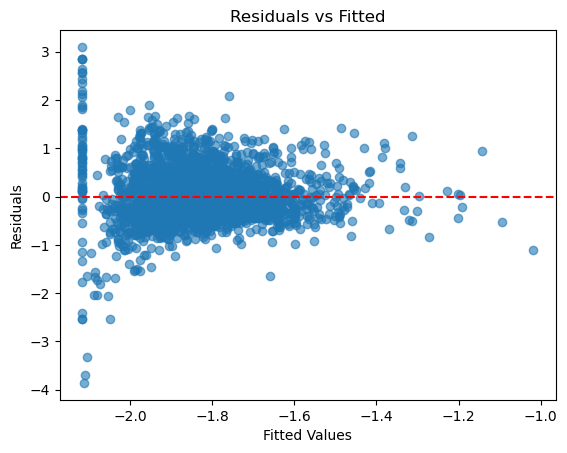

Heteroscedacity evaluation for transportation_and_warehousing_wage_share
bp_stat: 4.2278940137014995 | bp_pvalue: 0.03976475176993605


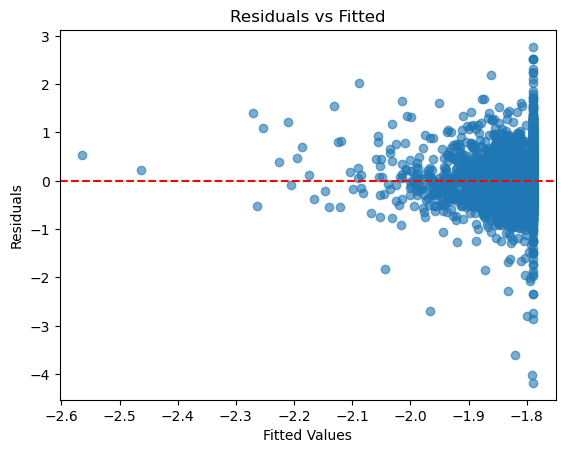

Heteroscedacity evaluation for trump_share
bp_stat: 13.09493077683755 | bp_pvalue: 0.00029609594289095007


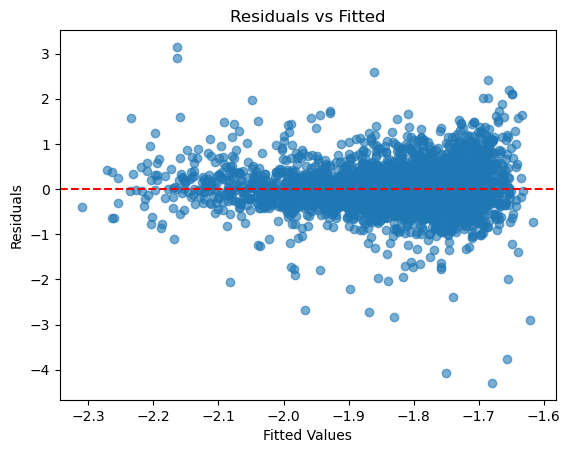

Heteroscedacity evaluation for unclassified_wage_share
bp_stat: 1.7156932898579769 | bp_pvalue: 0.19024835831979064


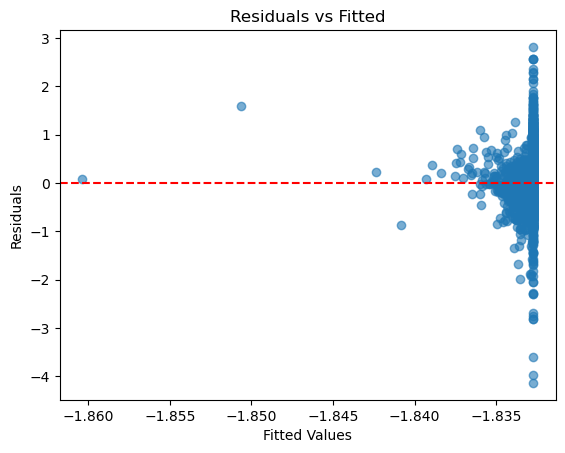

Heteroscedacity evaluation for utilities_wage_share
bp_stat: 10.569226806723282 | bp_pvalue: 0.001149858109798878


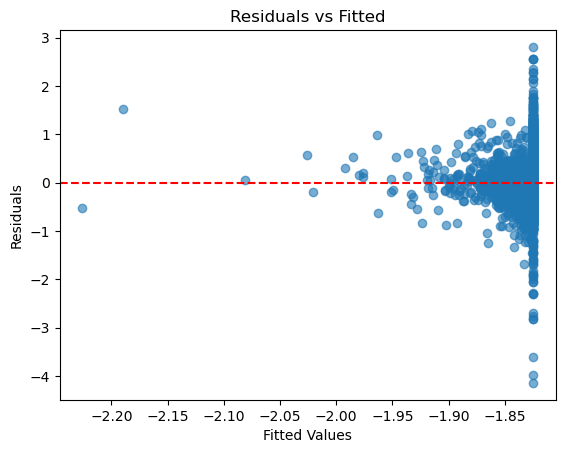

Heteroscedacity evaluation for white_pop_share
bp_stat: 4.284189431943838 | bp_pvalue: 0.038468420764053074


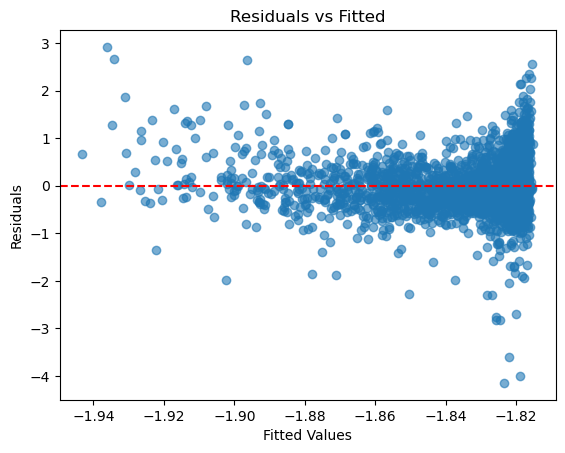

Heteroscedacity evaluation for wholesale_trade_wage_share
bp_stat: 6.829469559570765 | bp_pvalue: 0.008966589008307125


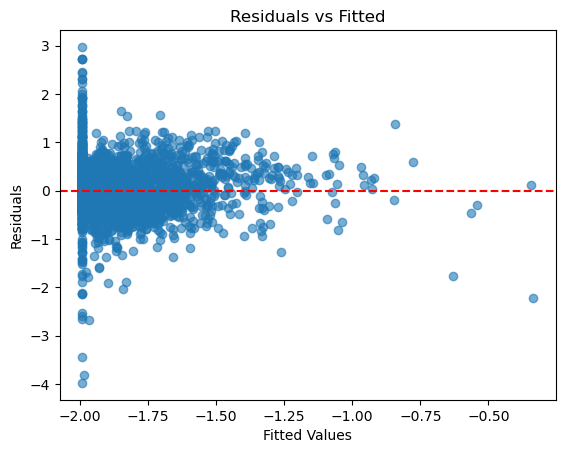

Heteroscedacity evaluation for yoy_job_change_pct
bp_stat: 13.47395120225369 | bp_pvalue: 0.00024189836695065676


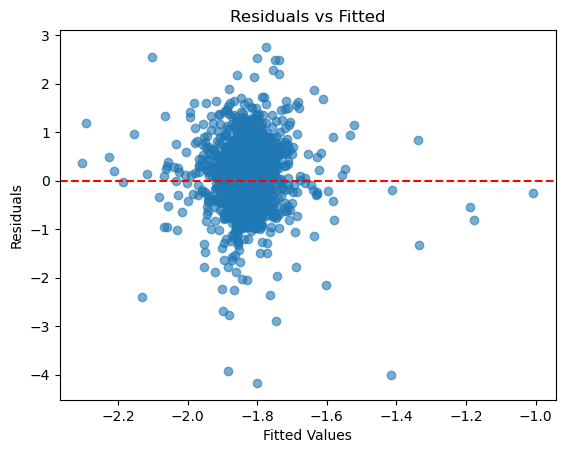

In [70]:
import pandas as pd
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residual_v_fitted(model):
    fitted = model.fittedvalues
    residuals = model.resid
    features = model.model.exog
    
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, features)
    print(f'bp_stat: {bp_stat} | bp_pvalue: {bp_pvalue}')
    plt.scatter(fitted, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    plt.show()
    return bp_stat, bp_pvalue

def isolate_het_residuals(model):
    
    df = model.model.data.frame
    feature_names = model.model.exog_names[1:]
    dep_var = model.model.endog_names
    
    results = []
    for feature in feature_names:
        if not feature.startswith('C(') and feature != target:
            print(f'Heteroscedacity evaluation for {feature}')
            formula = f'{dep_var} ~ np.arcsinh({feature})'
            test_model = smf.ols(formula, data=df).fit(cov_type='HC3')
            bp_stat, bp_pvalue = plot_residual_v_fitted(test_model)
            results.append({
                'feature': feature,
                'bp_stat': bp_stat,
                'bp_pvalue': bp_pvalue
            })
    return pd.DataFrame(results)

het_results = isolate_het_residuals(base_model)

In [71]:
problem_vars = het_results[het_results['bp_pvalue'] <= 0.001]
concern_vars = het_results[(het_results['bp_pvalue'] > 0.001) & (het_results['bp_pvalue'] <= 0.05)]

print('Problems')
display(problem_vars)

print('Concerns')
display(concern_vars)

Problems


feature     bp_stat  \
0          accommodation_and_food_services_wage_share   61.211541   
1        administrative_and_waste_services_wage_share   23.390543   
3        arts_entertainment_and_recreation_wage_share   15.568182   
6                             construction_wage_share   11.427776   
7                     educational_services_wage_share   12.849870   
8                    finance_and_insurance_wage_share   29.230391   
9        health_care_and_social_assistance_wage_share   42.614038   
11                             information_wage_share   30.129641   
12  management_of_companies_and_enterprises_wage_s...   20.703246   
13                           manufacturing_wage_share   71.748610   
14  mining_quarrying_and_oil_and_gas_extraction_wa...   11.979731   
15                                   native_pop_share   14.466393   
16  other_services_except_public_administration_wa...   49.189485   
17     professional_and_technical_services_wage_share   33.217970   
18      real_estate_and_rental_and_leasing_wage_share   48.210914   
19                            retail_trade_wage_share  169.987475   
21                                        trump_share   13.094931   
26                                 yoy_job_change_pct   13.473951   

       bp_pvalue  
0   5.126015e-15  
1   1.322270e-06  
3   7.958262e-05  
6   7.235423e-04  
7   3.375027e-04  
8   6.426329e-08  
9   6.667912e-11  
11  4.041073e-08  
12  5.362501e-06  
13  2.444361e-17  
14  5.378236e-04  
15  1.426826e-04  
16  2.323931e-12  
17  8.238564e-09  
18  3.827520e-12  
19  7.445639e-39  
21  2.960959e-04  
26  2.418984e-04

Concerns


feature    bp_stat  bp_pvalue
2   agriculture_forestry_fishing_and_hunting_wage_...   8.551527   0.003452
5                                     black_pop_share   6.124842   0.013330
20          transportation_and_warehousing_wage_share   4.227894   0.039765
23                               utilities_wage_share  10.569227   0.001150
24                                    white_pop_share   4.284189   0.038468
25                         wholesale_trade_wage_share   6.829470   0.008967

bp_stat: 8.491913464681033e-05 | bp_pvalue: 0.9926474718686668


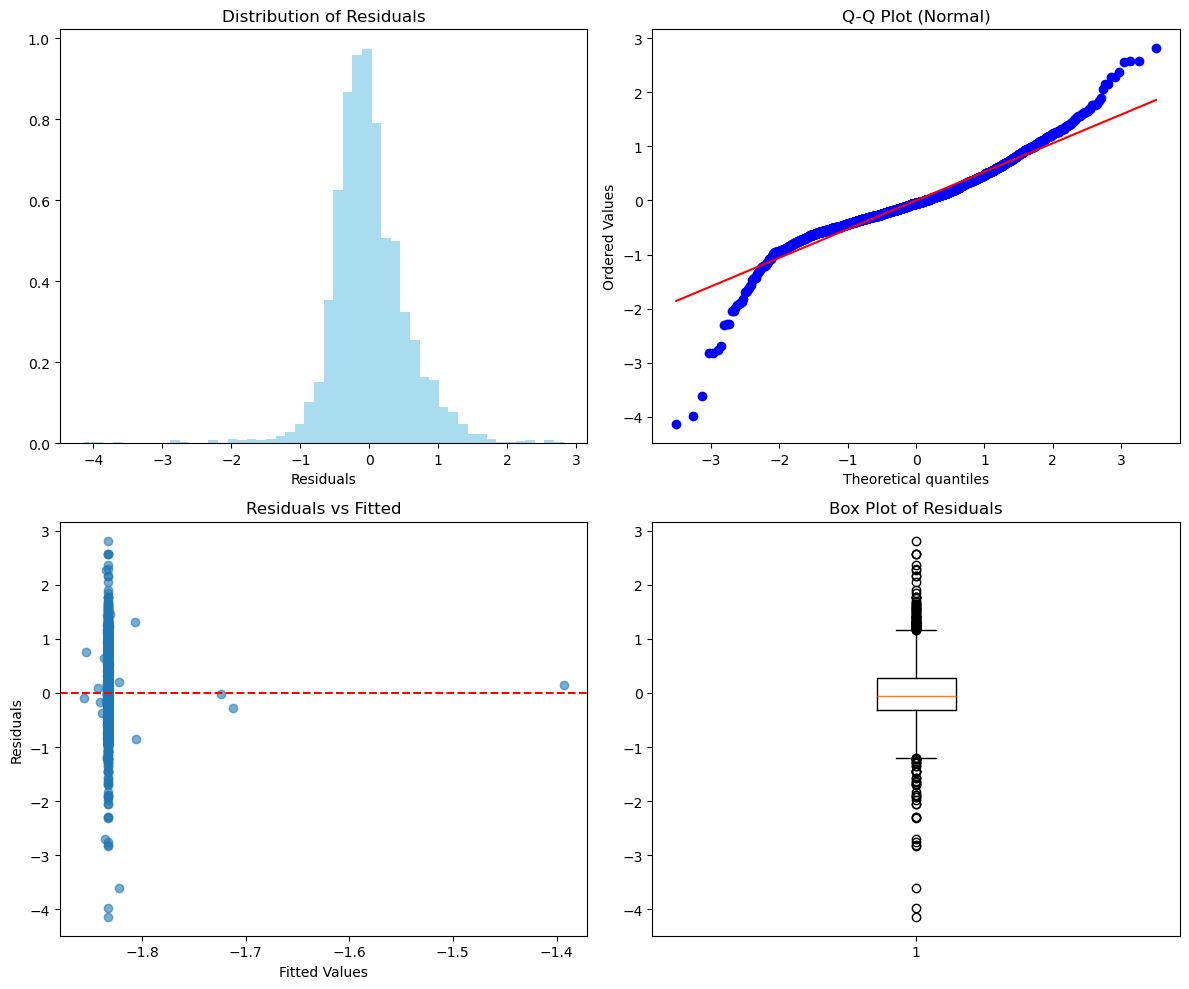

In [42]:
t_model = smf.ols(f'np.log(wage_adjusted_ppp_loan_amount) ~ np.power(yoy_job_change_pct, 5)', data=df).fit(cov_type='HC3')
me.test_model_assumptions(t_model)

In [43]:
import scipy as sp

sp.stats.boxcox(no_loc_df['white_pop_share'])

(array([-0.1442613 , -0.1583339 , -0.03479944, ..., -0.01832329,
        -0.07310516, -0.04385661], shape=(3102,)),
 np.float64(4.665096145858847))

Evaluating bp_stat for: yoy_job_change_pct
bp_stat: 9.767913635836672 | bp_pvalue: 0.0017758386023370876


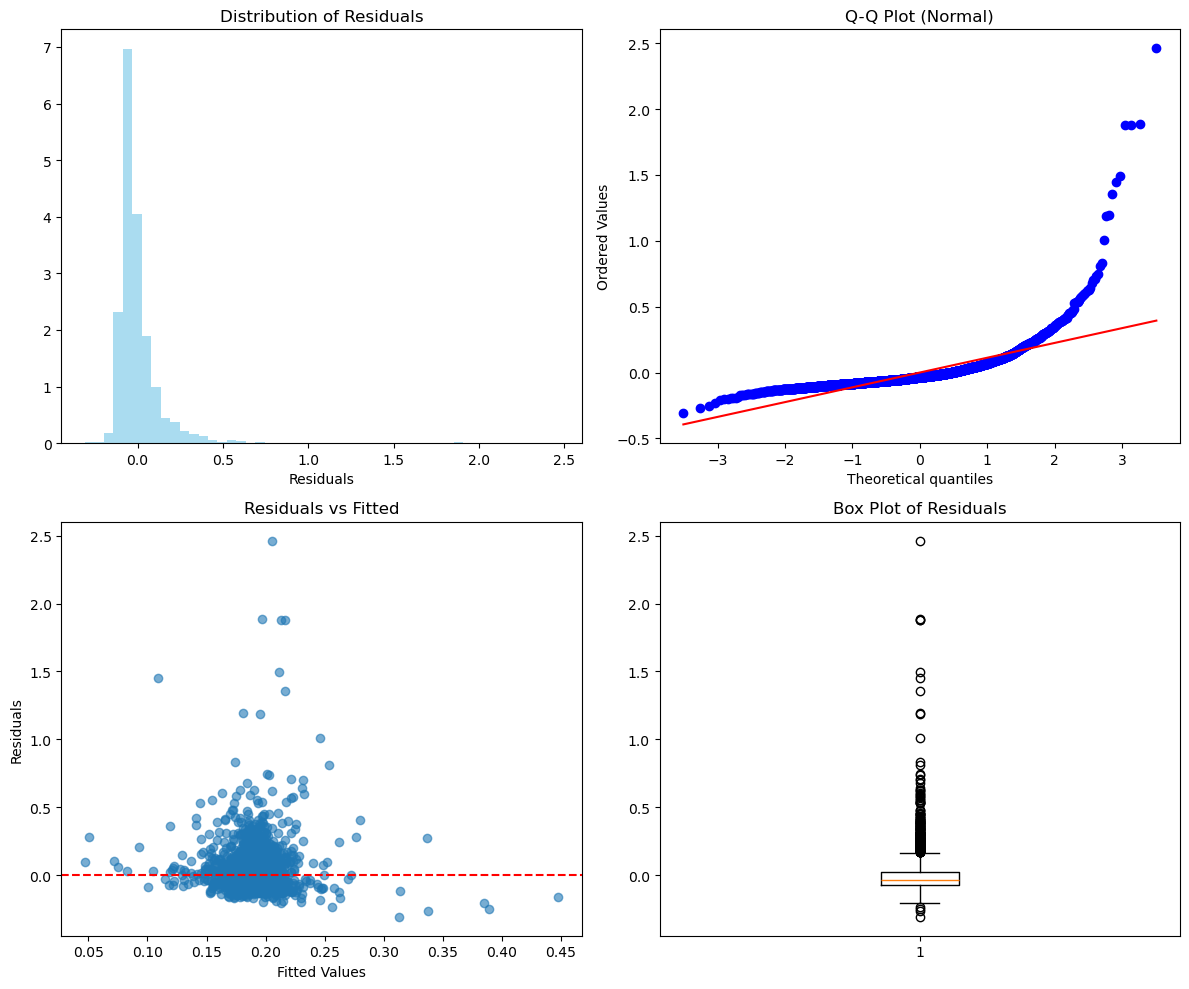

Evaluating bp_stat for: white_pop_share
bp_stat: 20.294811709668124 | bp_pvalue: 6.638034202809763e-06


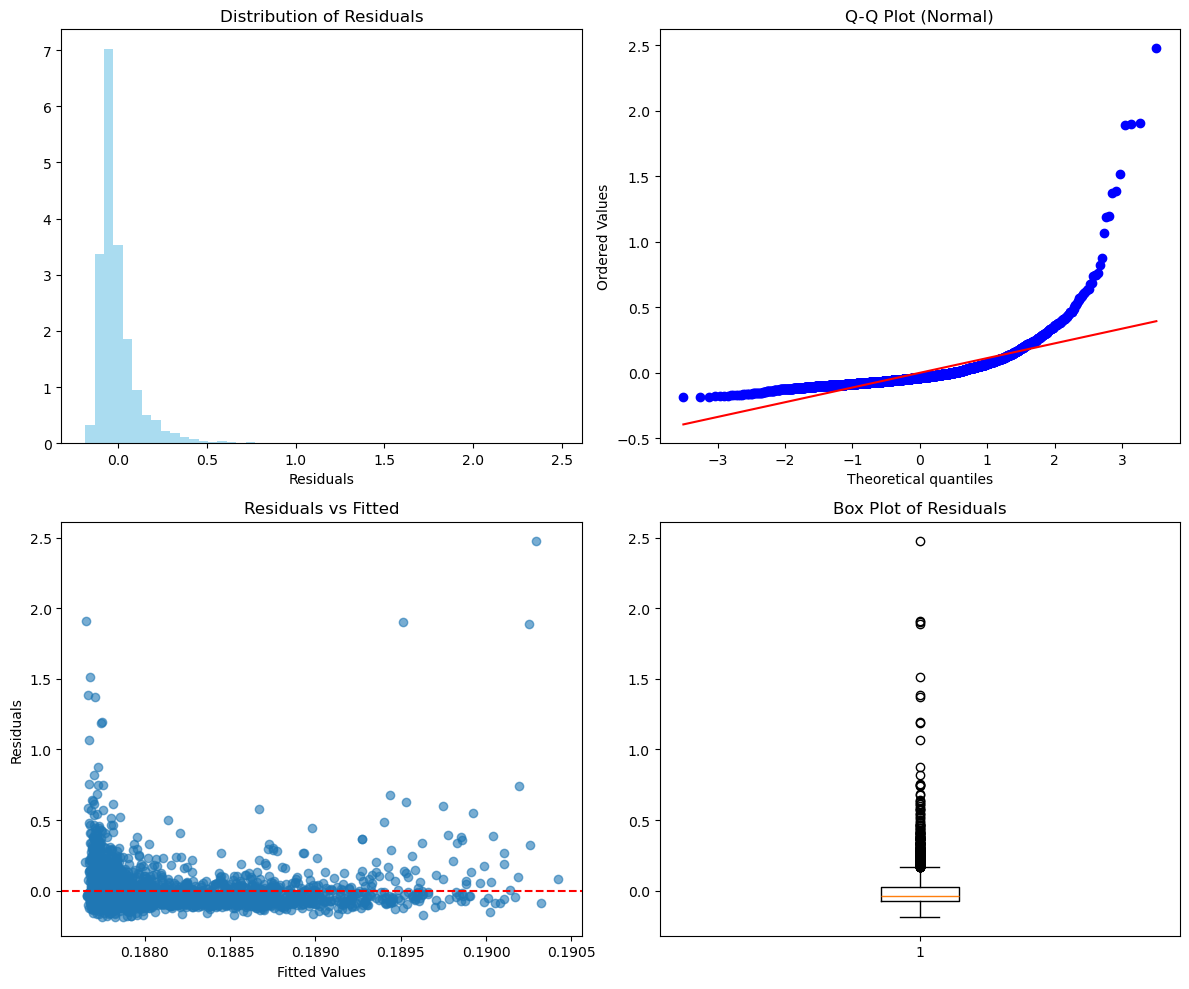

Evaluating bp_stat for: black_pop_share
bp_stat: 5.083328859954564 | bp_pvalue: 0.024156946964645414


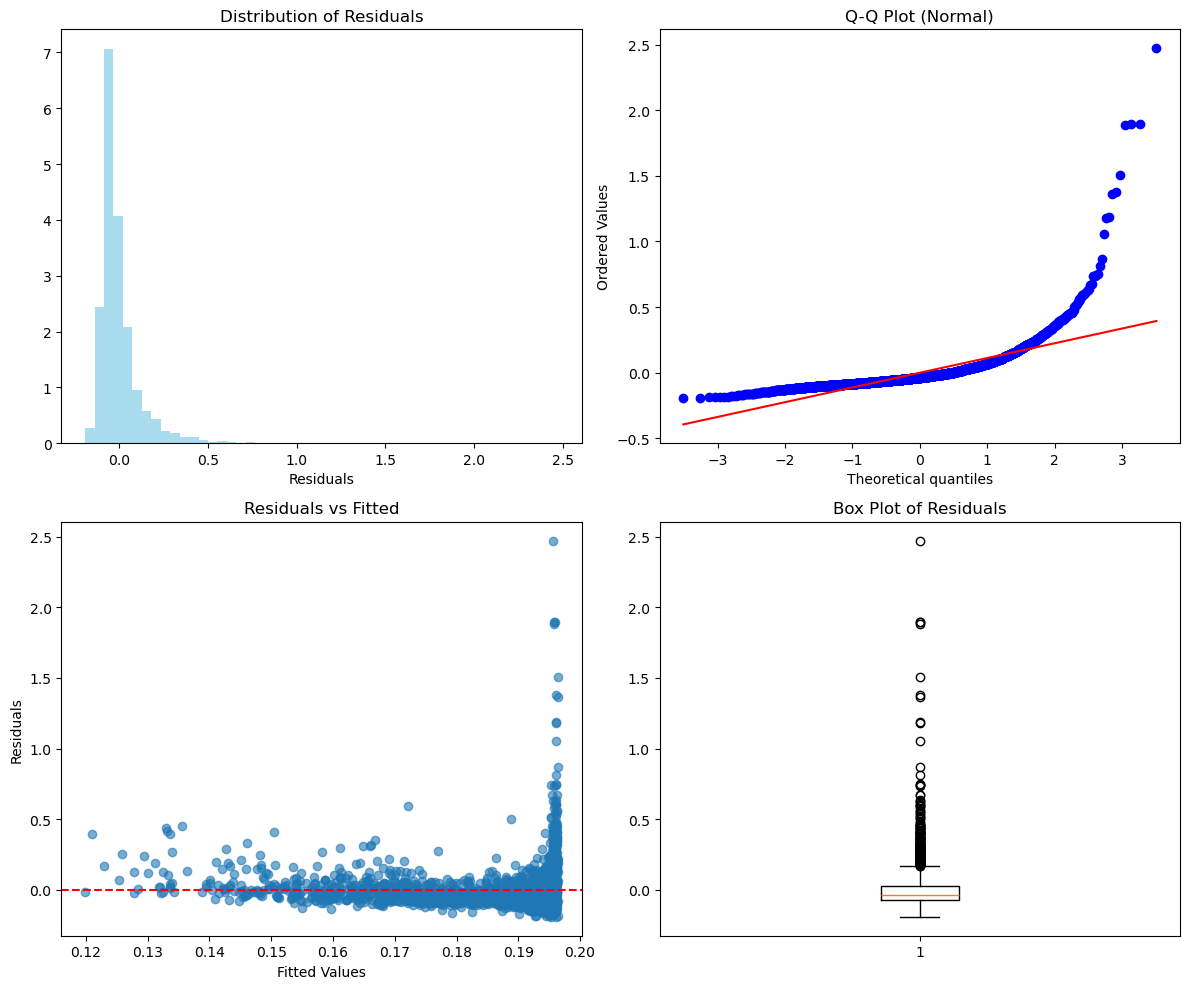

Evaluating bp_stat for: asian_pop_share
bp_stat: 2.405625095172492 | bp_pvalue: 0.12089982249509362


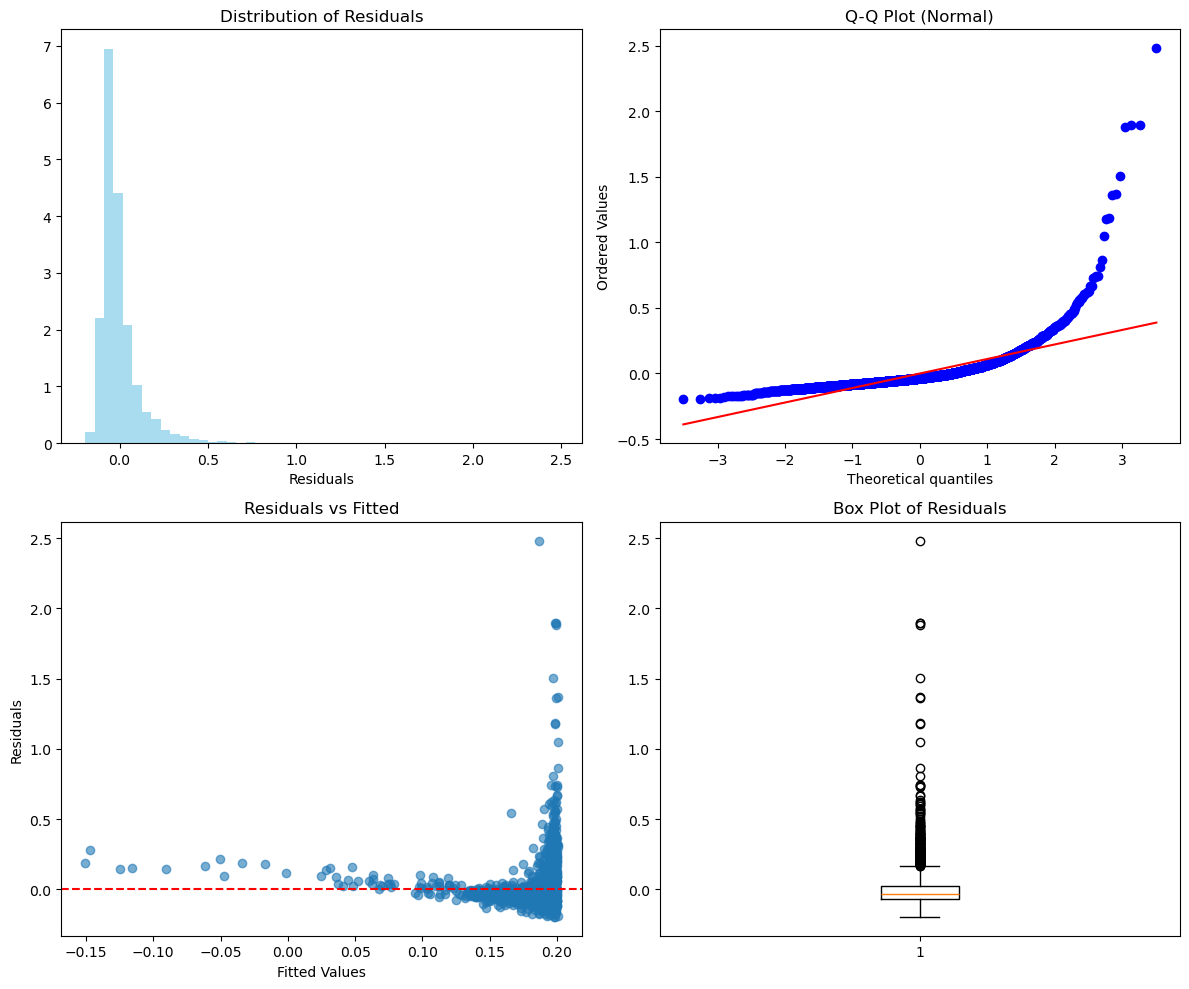

Evaluating bp_stat for: native_pop_share
bp_stat: 186.4789304107018 | bp_pvalue: 1.866128085376043e-42


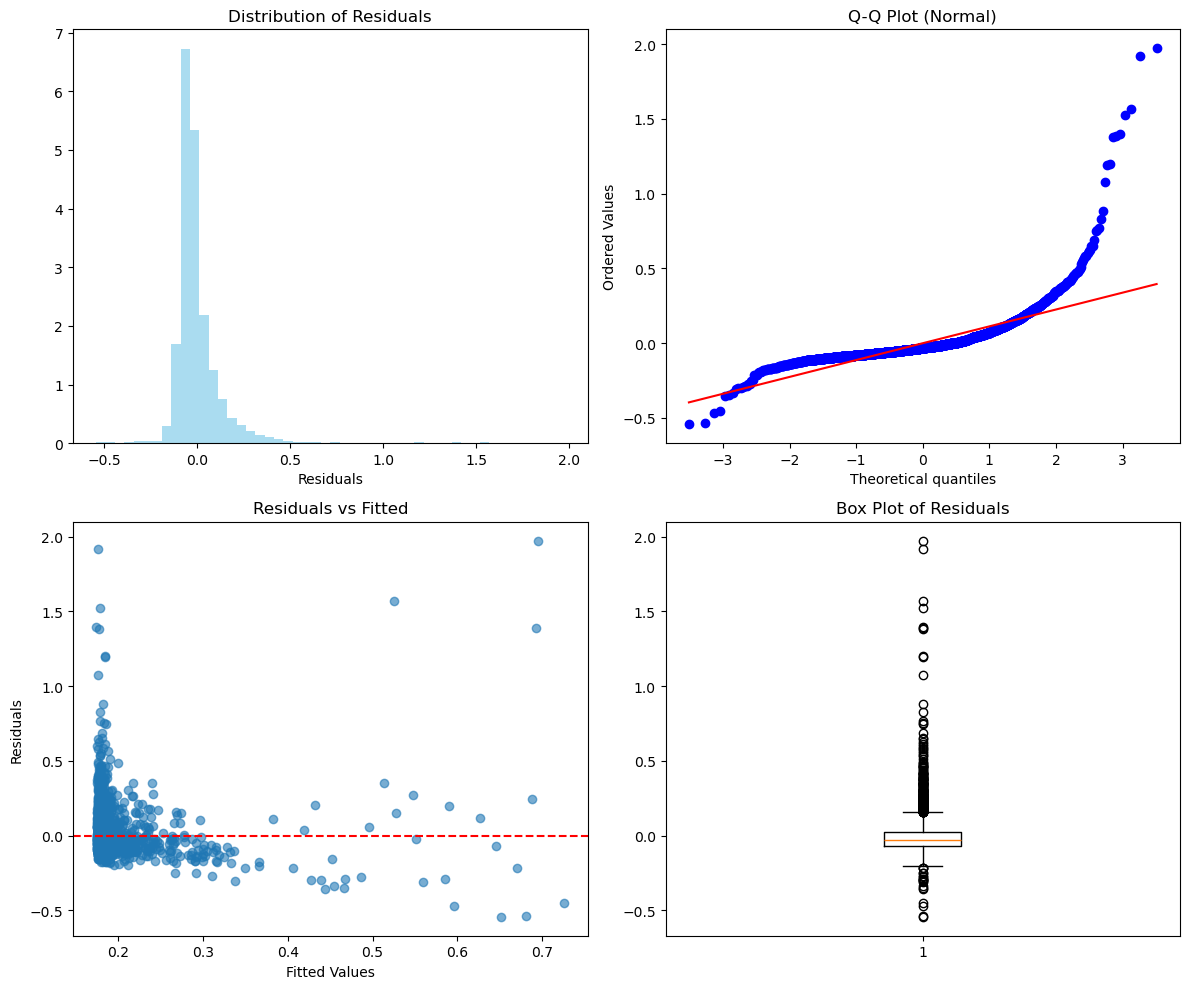

Evaluating bp_stat for: hispanic_share
bp_stat: 4.6203176324977555 | bp_pvalue: 0.031595386889813955


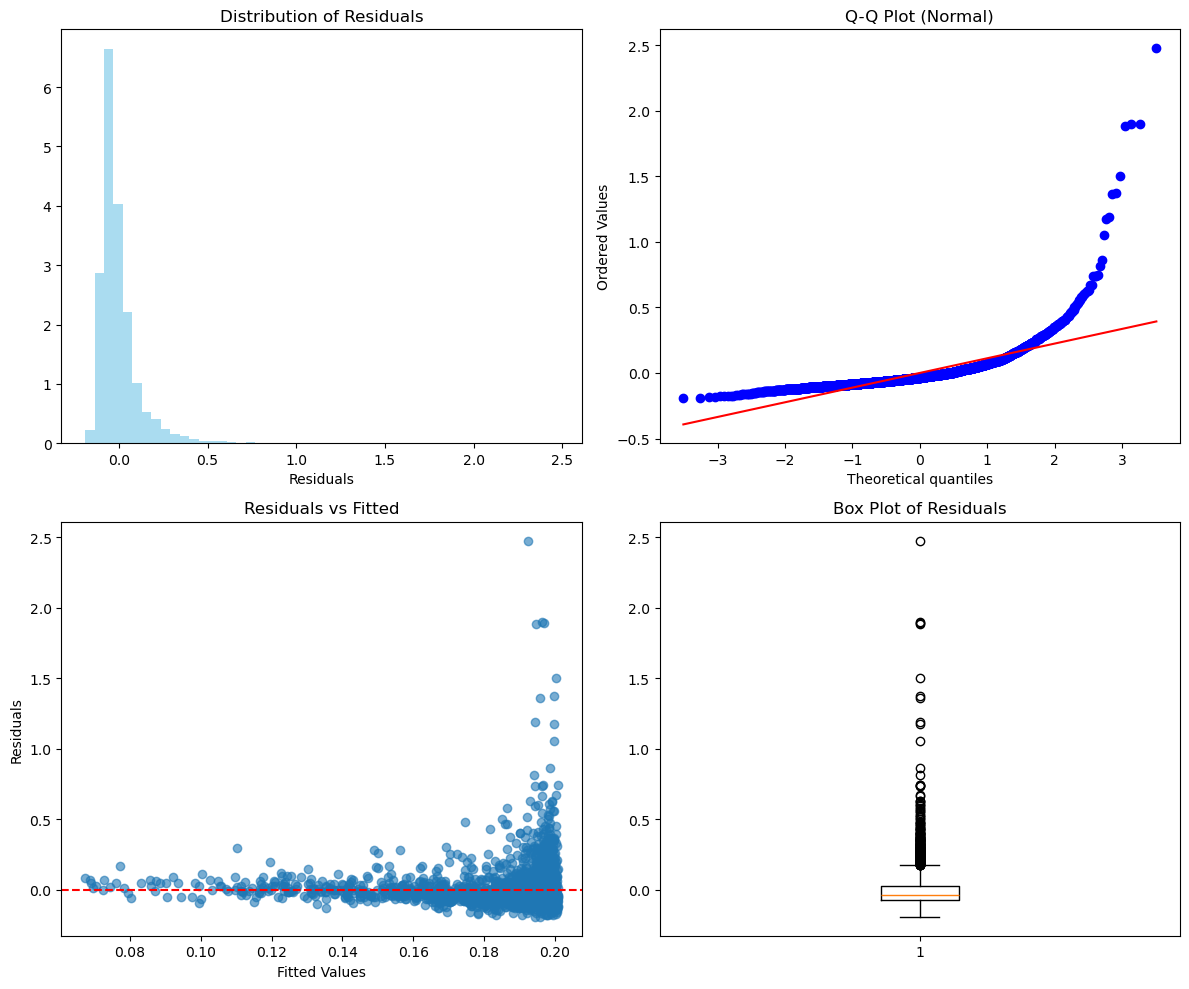

Evaluating bp_stat for: trump_share
bp_stat: 0.30569254123169465 | bp_pvalue: 0.5803355218365818


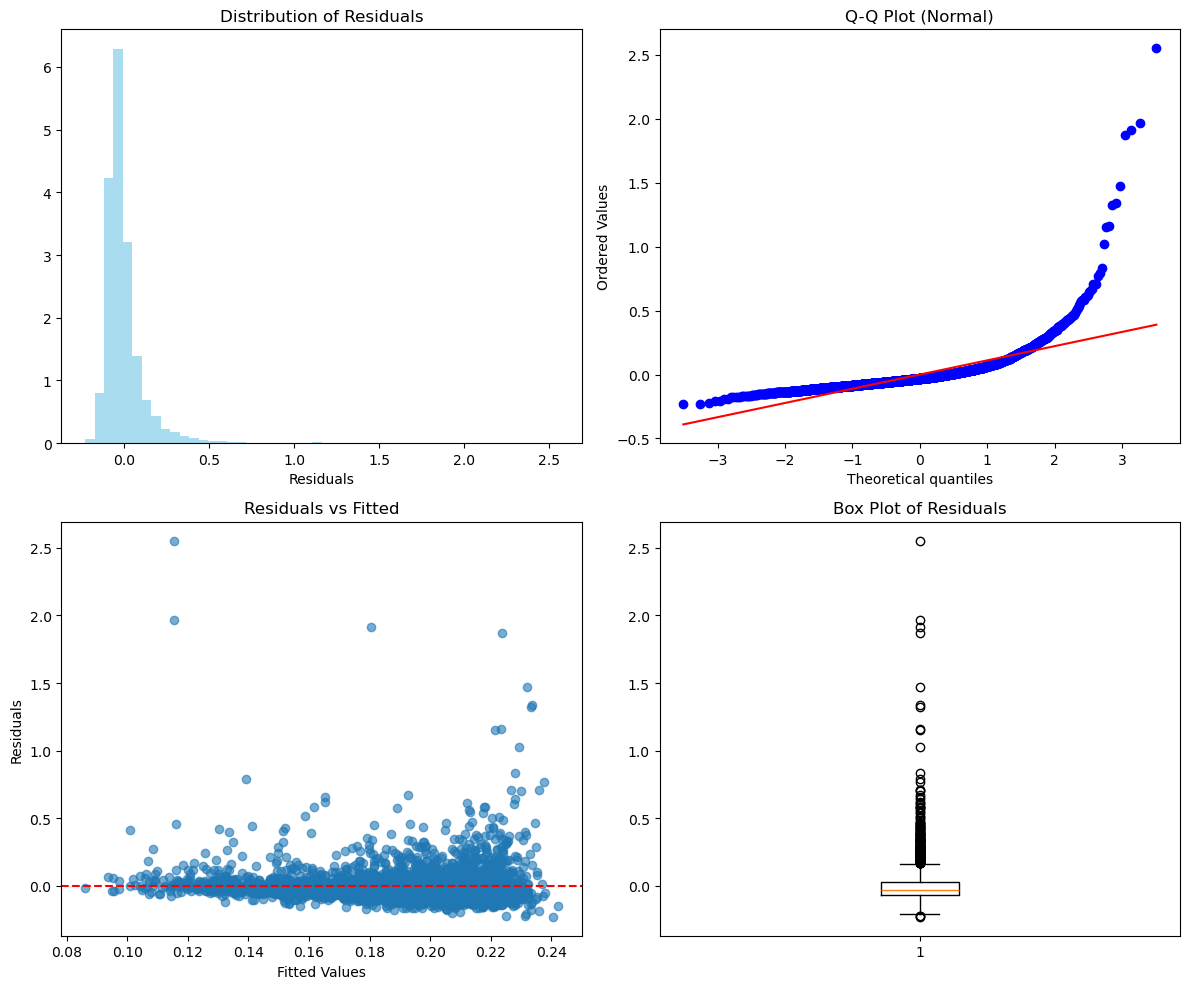

Evaluating bp_stat for: accommodation_and_food_services_wage_share
bp_stat: 6.0604050451262035 | bp_pvalue: 0.013824597307099779


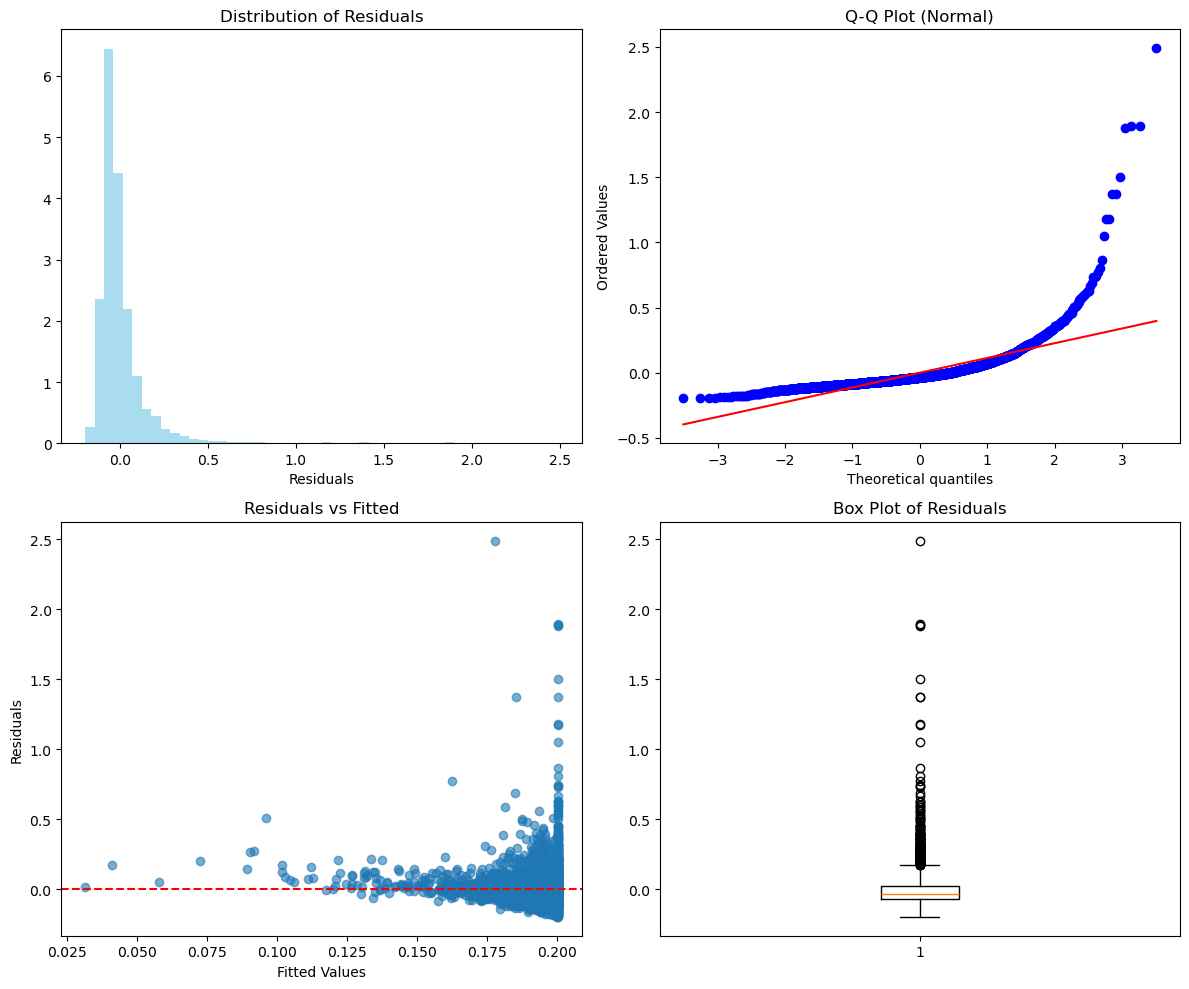

Evaluating bp_stat for: administrative_and_waste_services_wage_share
bp_stat: 13.43513742625356 | bp_pvalue: 0.00024695489277360723


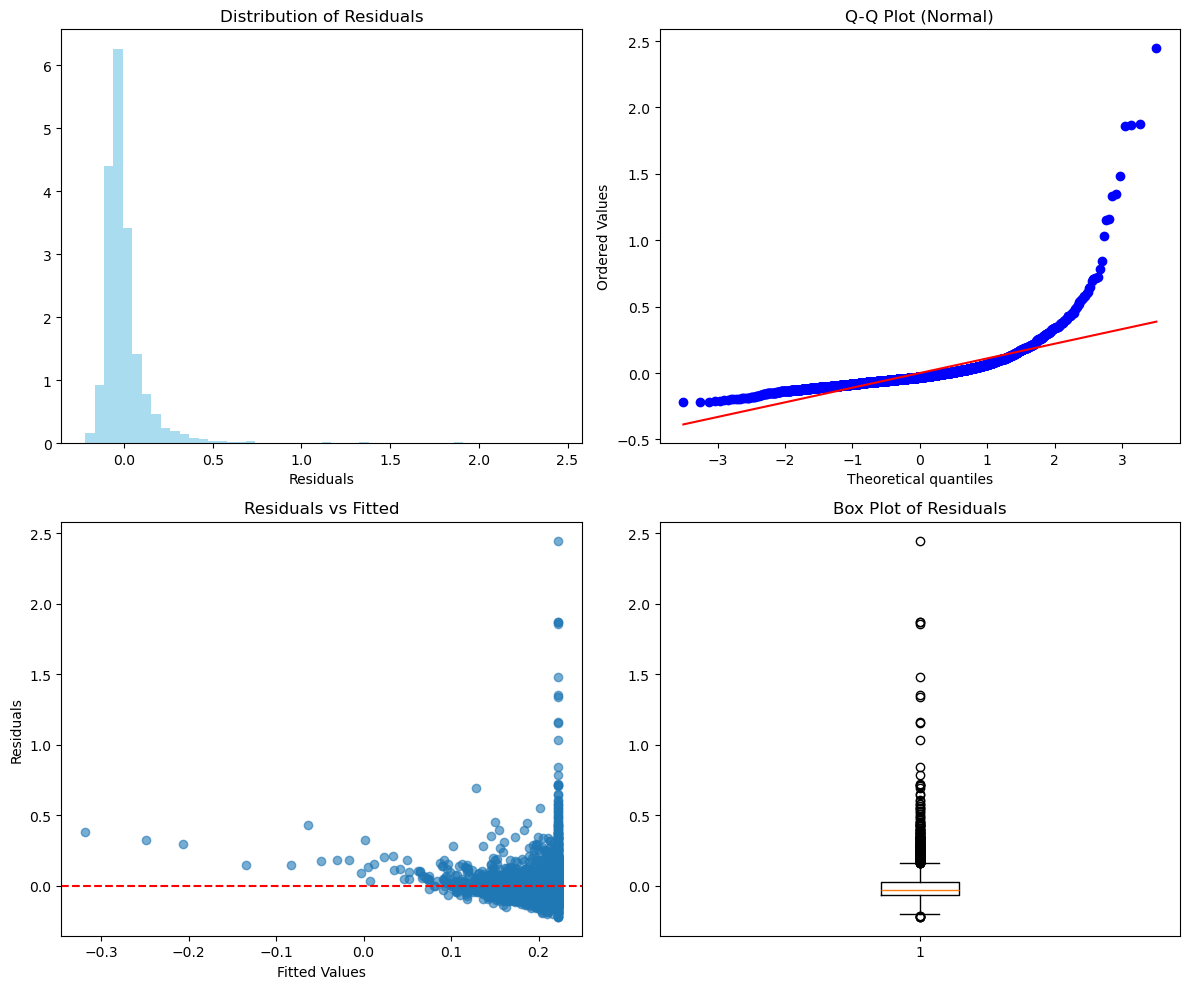

Evaluating bp_stat for: agriculture_forestry_fishing_and_hunting_wage_share
bp_stat: 40.4722055620103 | bp_pvalue: 1.9943295520931703e-10


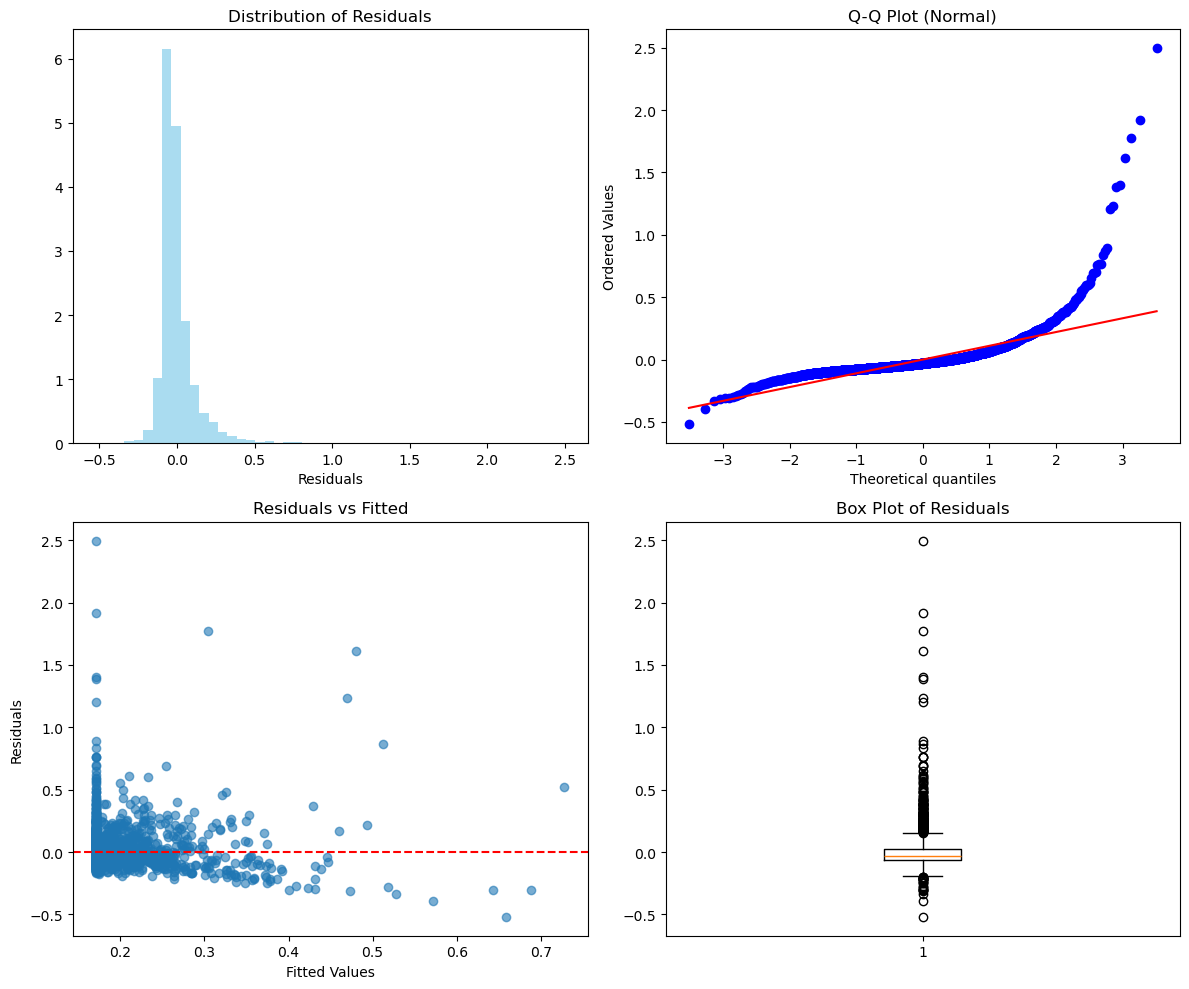

Evaluating bp_stat for: arts_entertainment_and_recreation_wage_share
bp_stat: 3.8779704784485327 | bp_pvalue: 0.04892366366409805


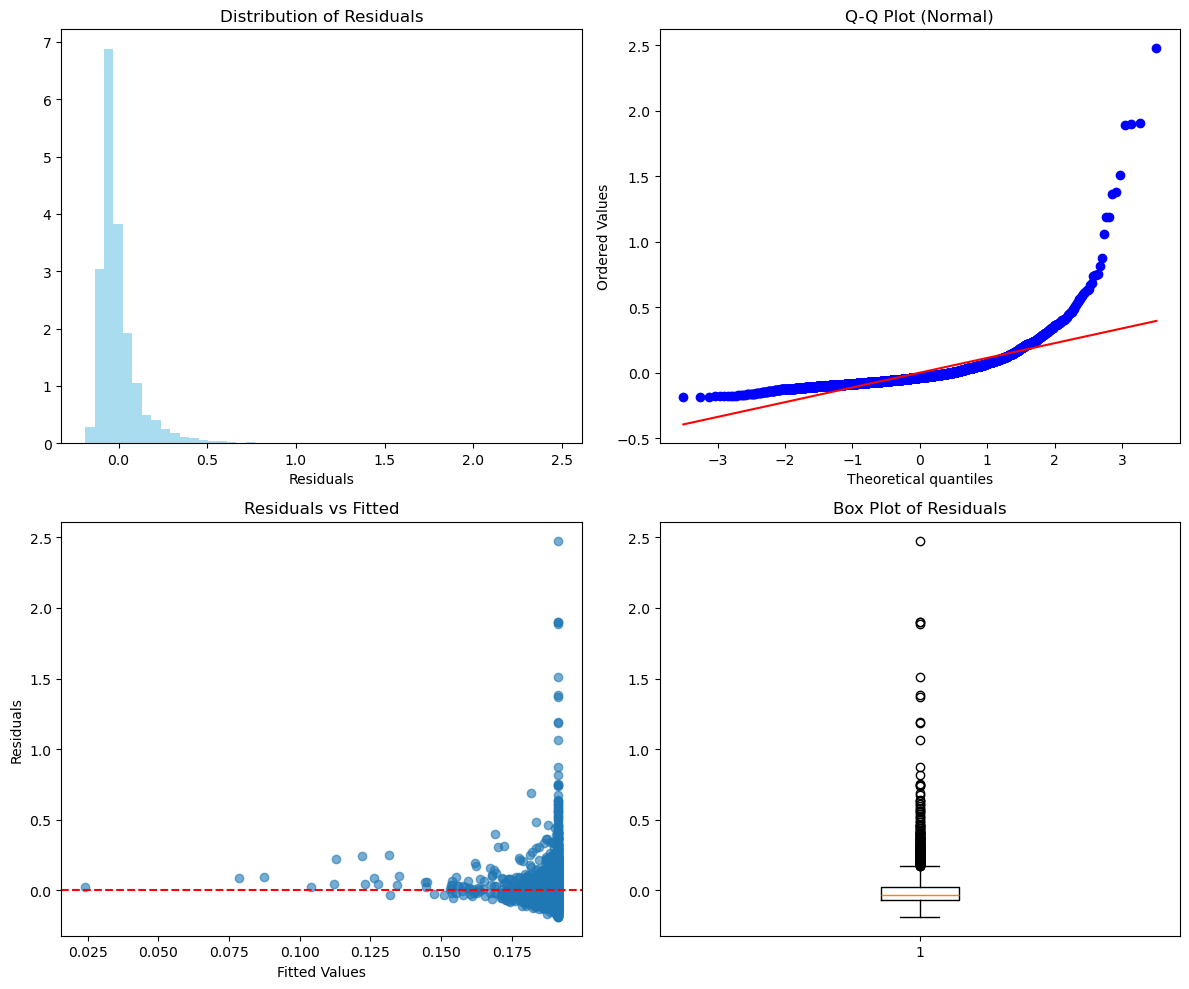

Evaluating bp_stat for: construction_wage_share
bp_stat: 15.614934772903828 | bp_pvalue: 7.763895117984293e-05


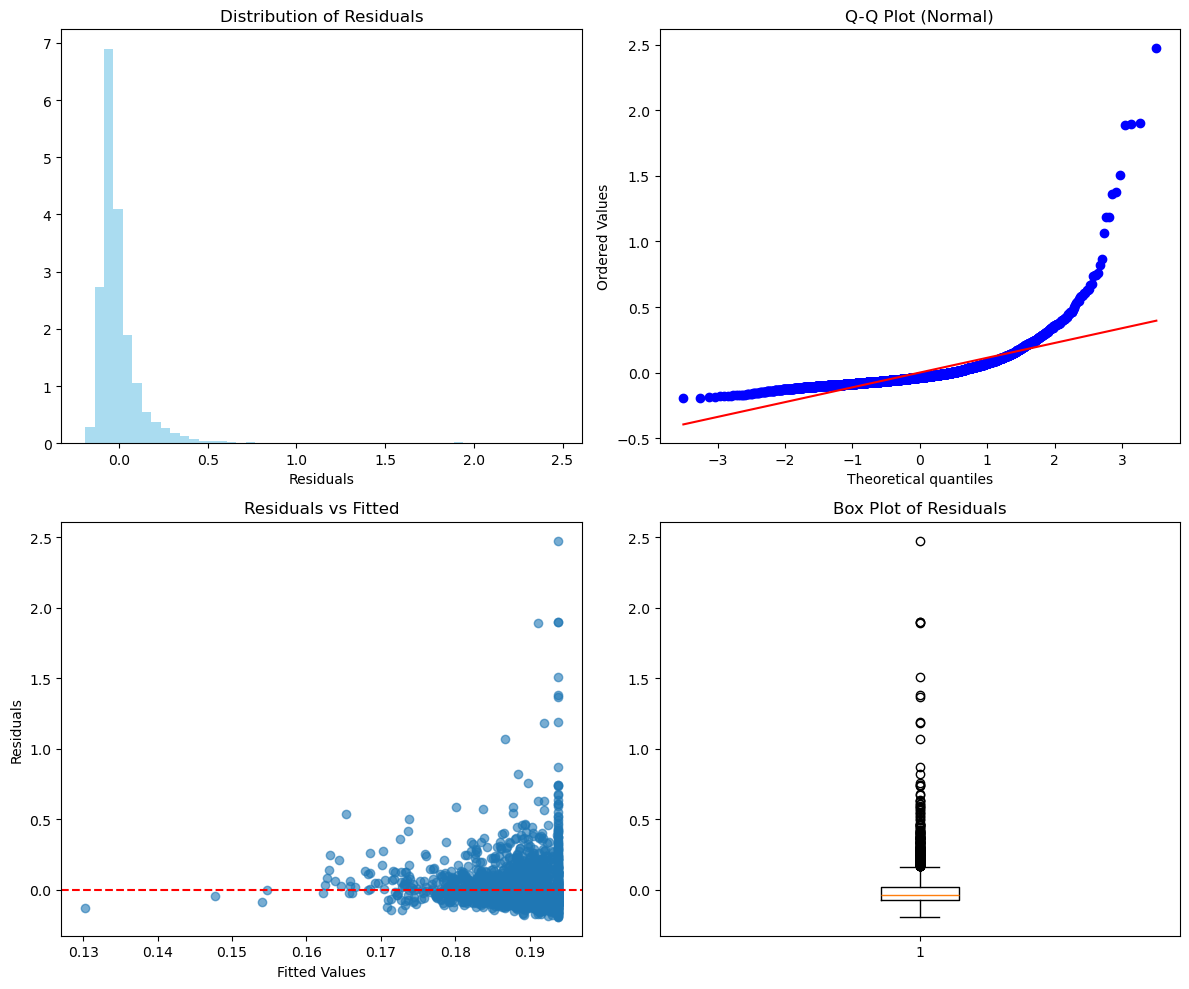

Evaluating bp_stat for: educational_services_wage_share
bp_stat: 3.870592659705468 | bp_pvalue: 0.049139166666967604


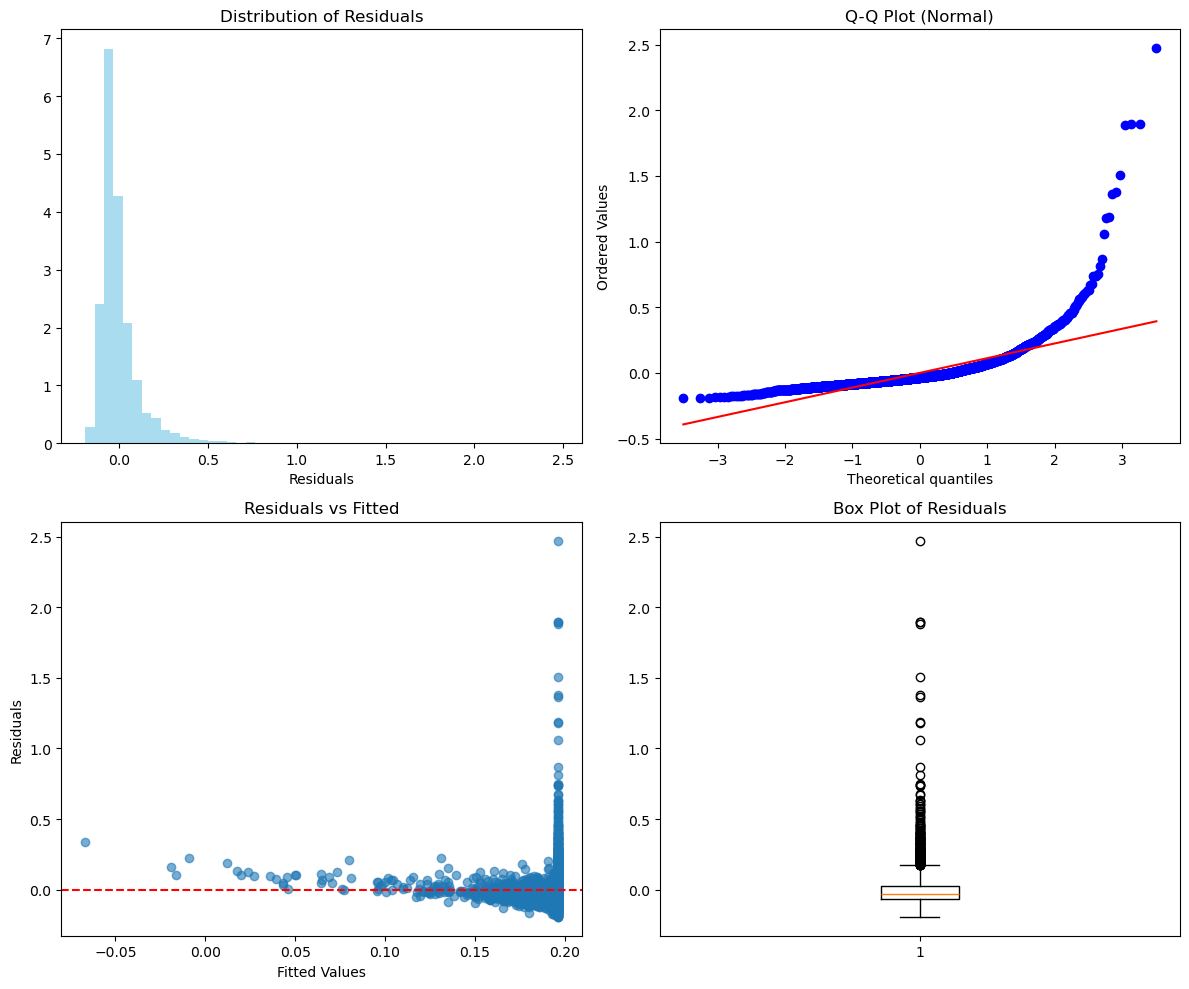

Evaluating bp_stat for: finance_and_insurance_wage_share
bp_stat: 11.407806626934383 | bp_pvalue: 0.0007313612711079844


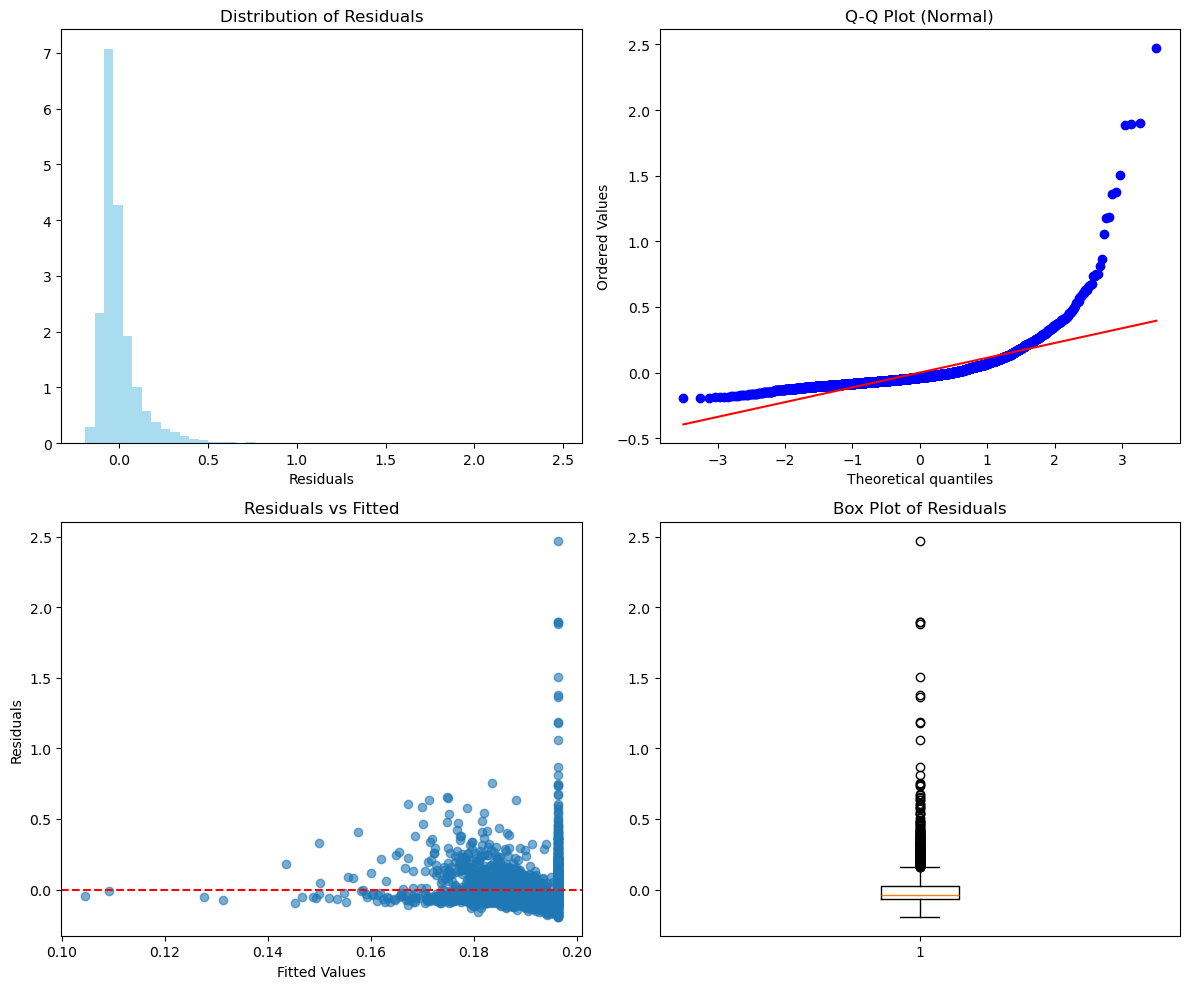

Evaluating bp_stat for: health_care_and_social_assistance_wage_share
bp_stat: 3.11969490594835 | bp_pvalue: 0.07735126501647764


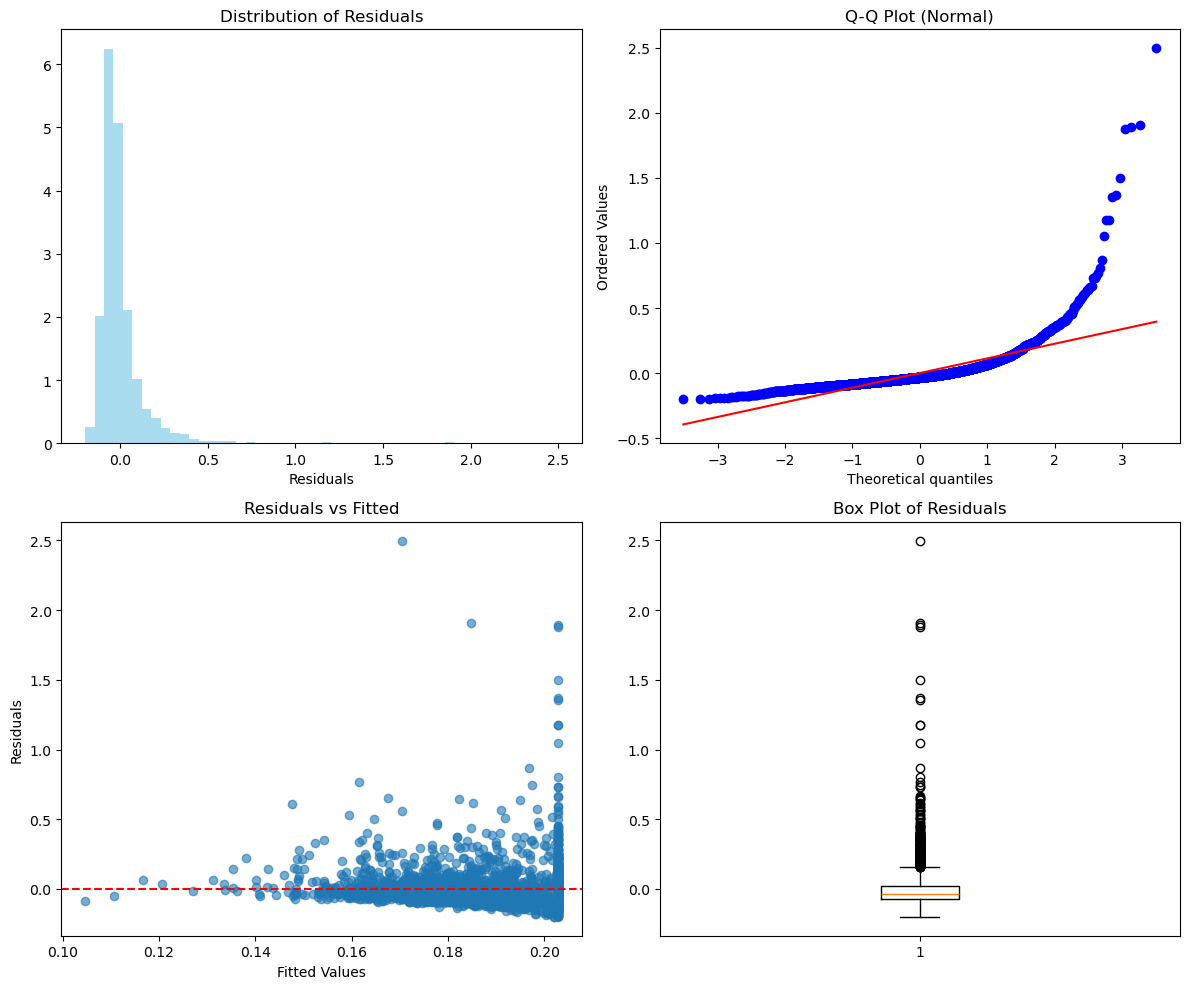

Evaluating bp_stat for: information_wage_share
bp_stat: 8.45884330839288 | bp_pvalue: 0.003632728056238592


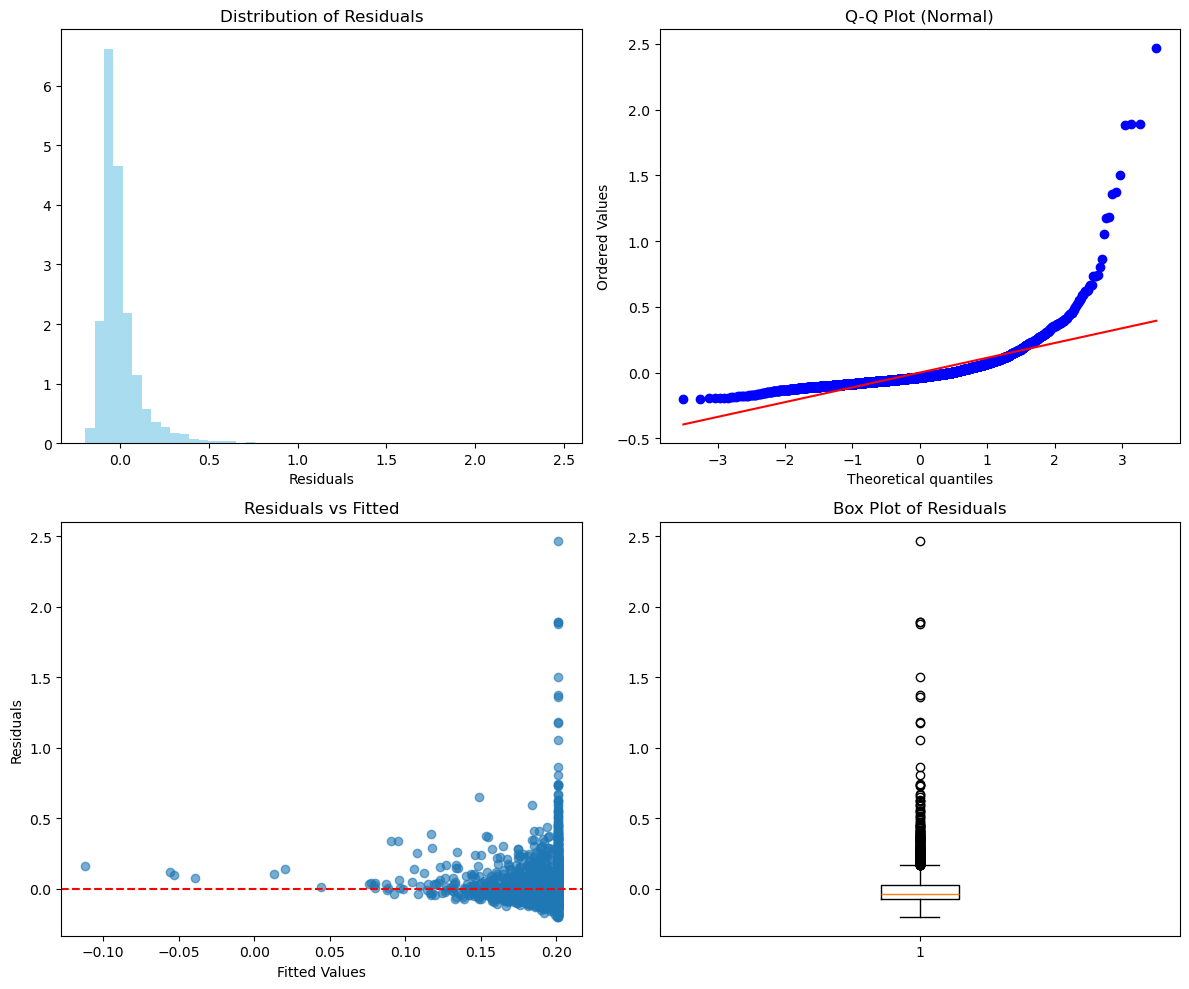

Evaluating bp_stat for: management_of_companies_and_enterprises_wage_share
bp_stat: 5.200062410232612 | bp_pvalue: 0.022586077220929892


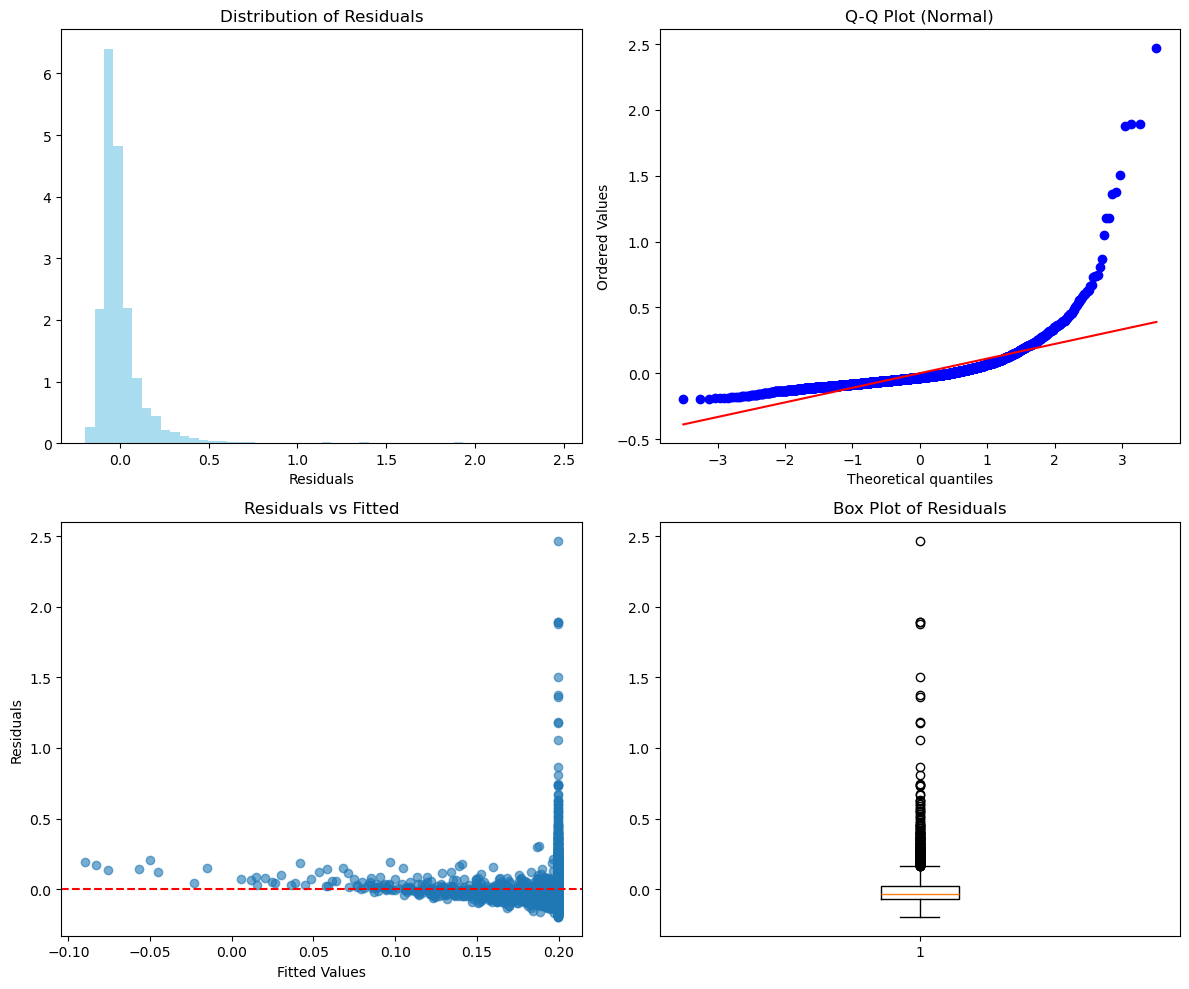

Evaluating bp_stat for: manufacturing_wage_share
bp_stat: 30.24951981145018 | bp_pvalue: 3.798852885333663e-08


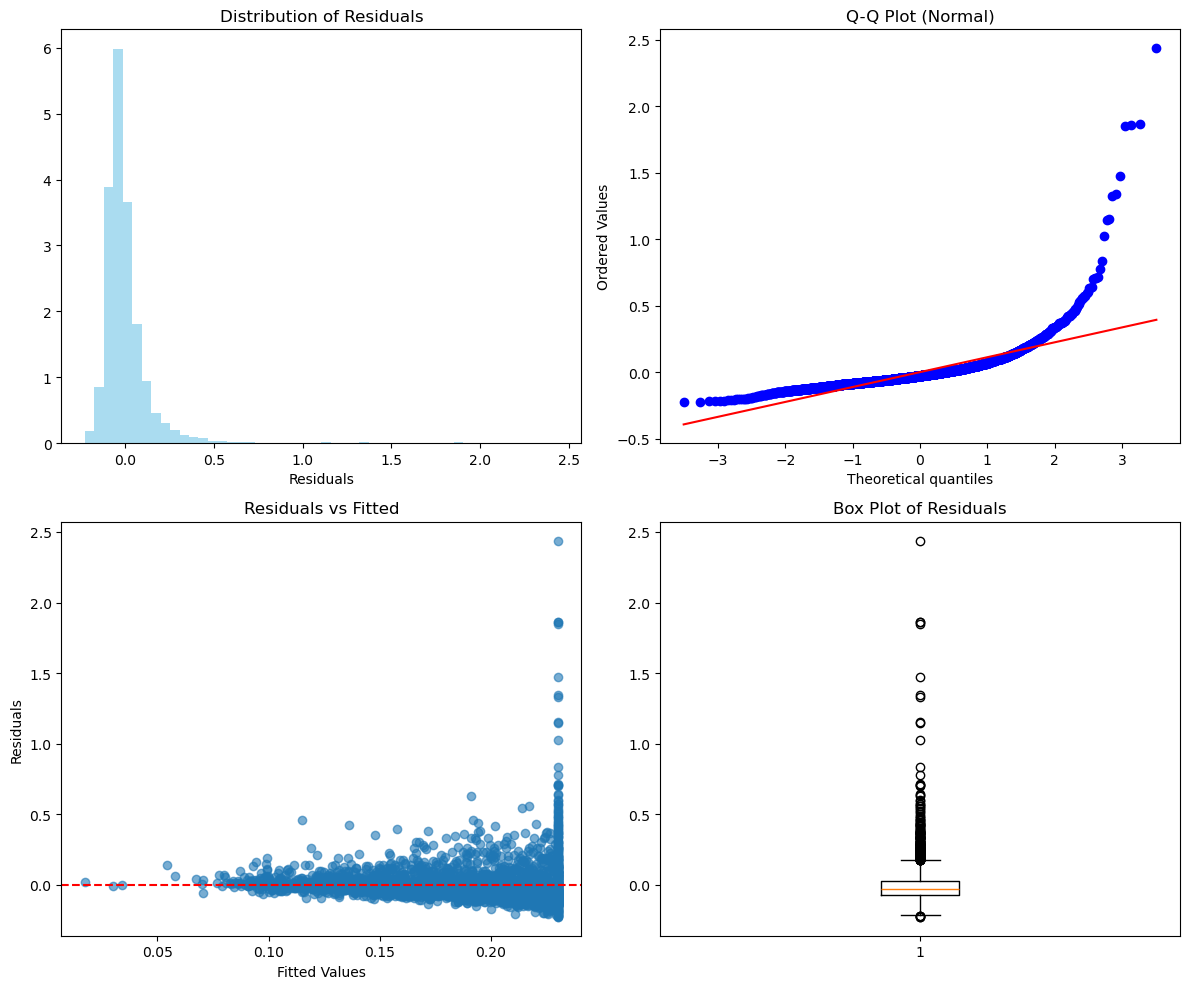

Evaluating bp_stat for: mining_quarrying_and_oil_and_gas_extraction_wage_share
bp_stat: 1.4288187817433118 | bp_pvalue: 0.23195731067700598


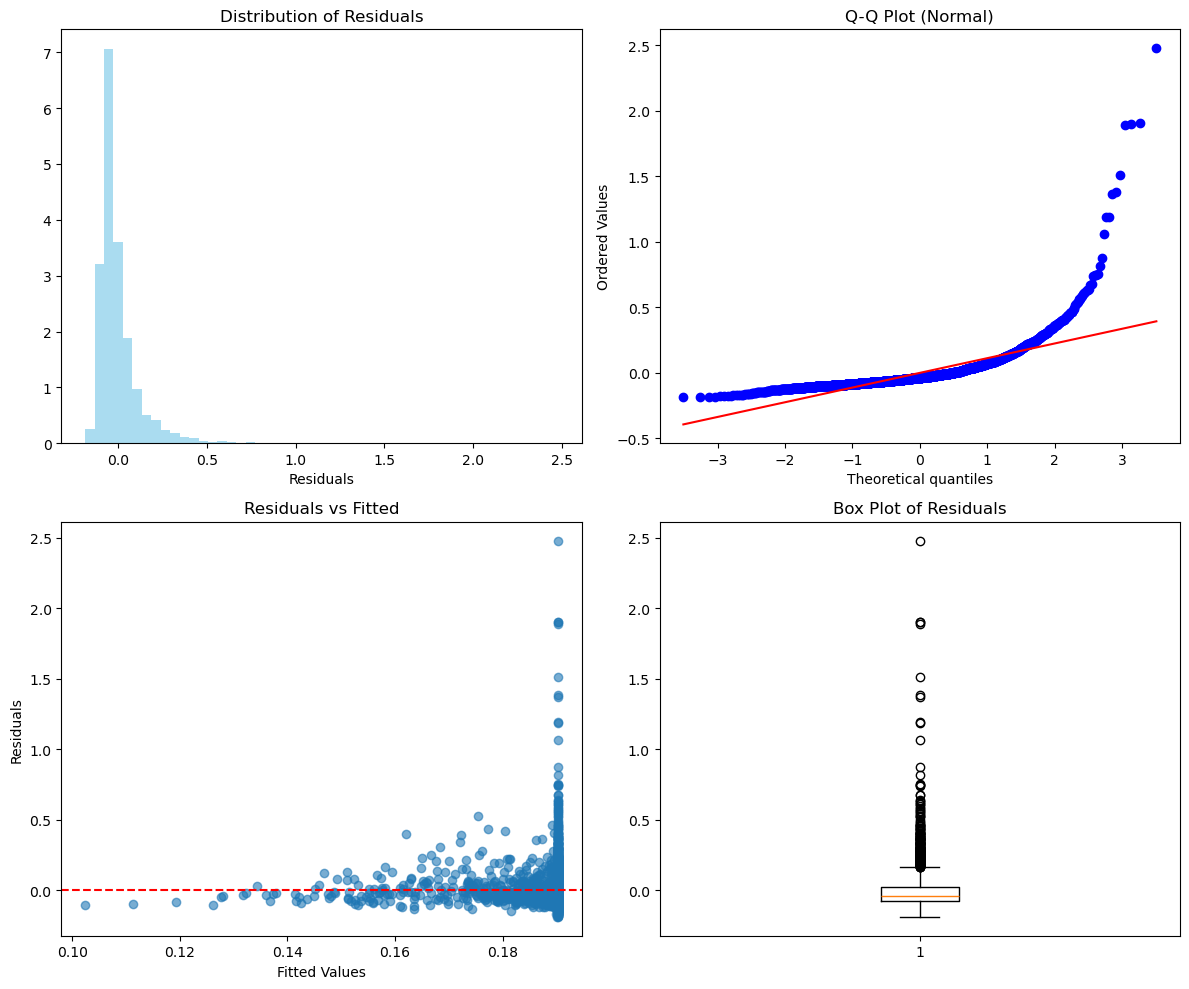

Evaluating bp_stat for: other_services_except_public_administration_wage_share
bp_stat: 21.30793222570797 | bp_pvalue: 3.91109771308132e-06


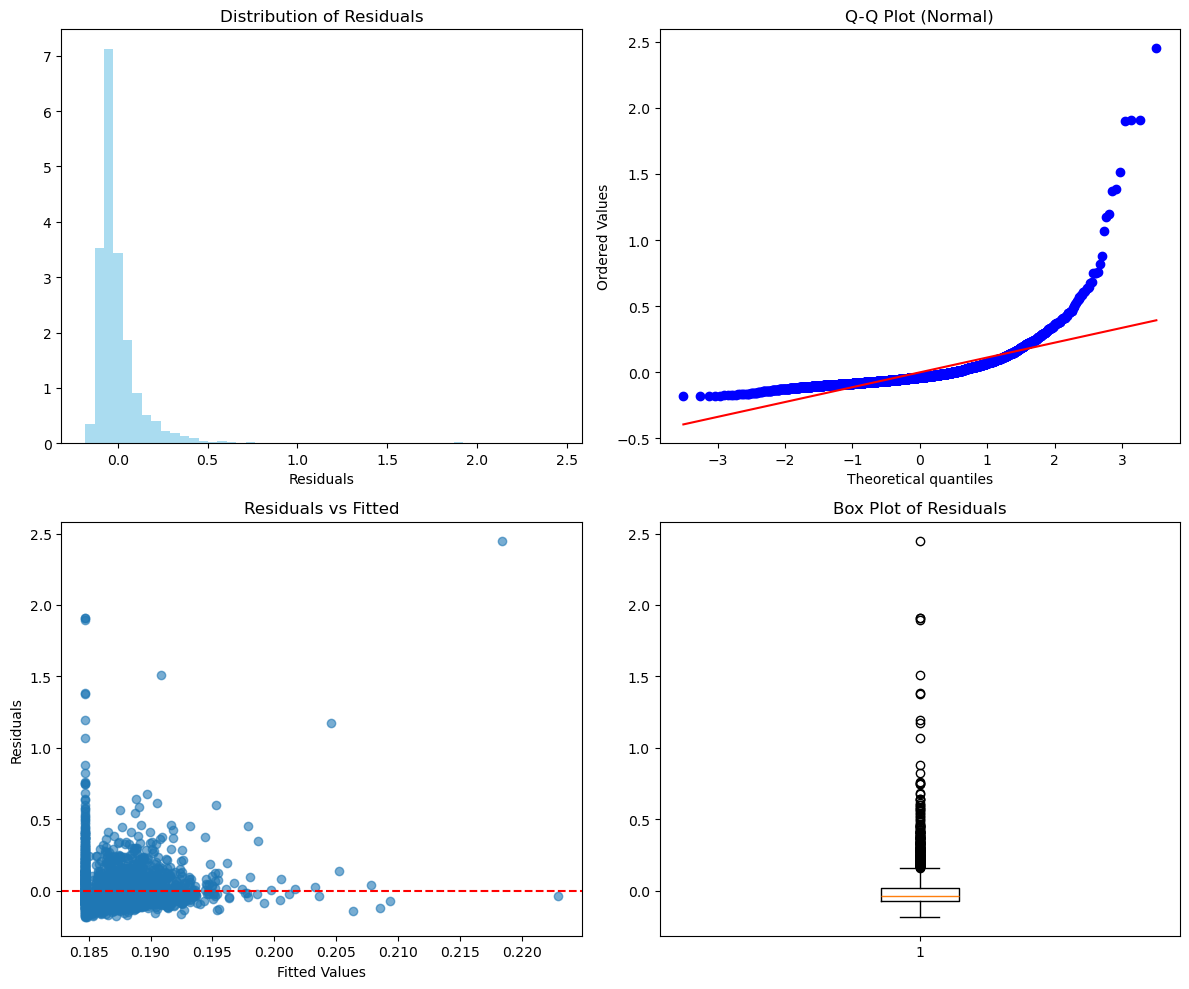

Evaluating bp_stat for: professional_and_technical_services_wage_share
bp_stat: 11.292891911666459 | bp_pvalue: 0.0007780439452600034


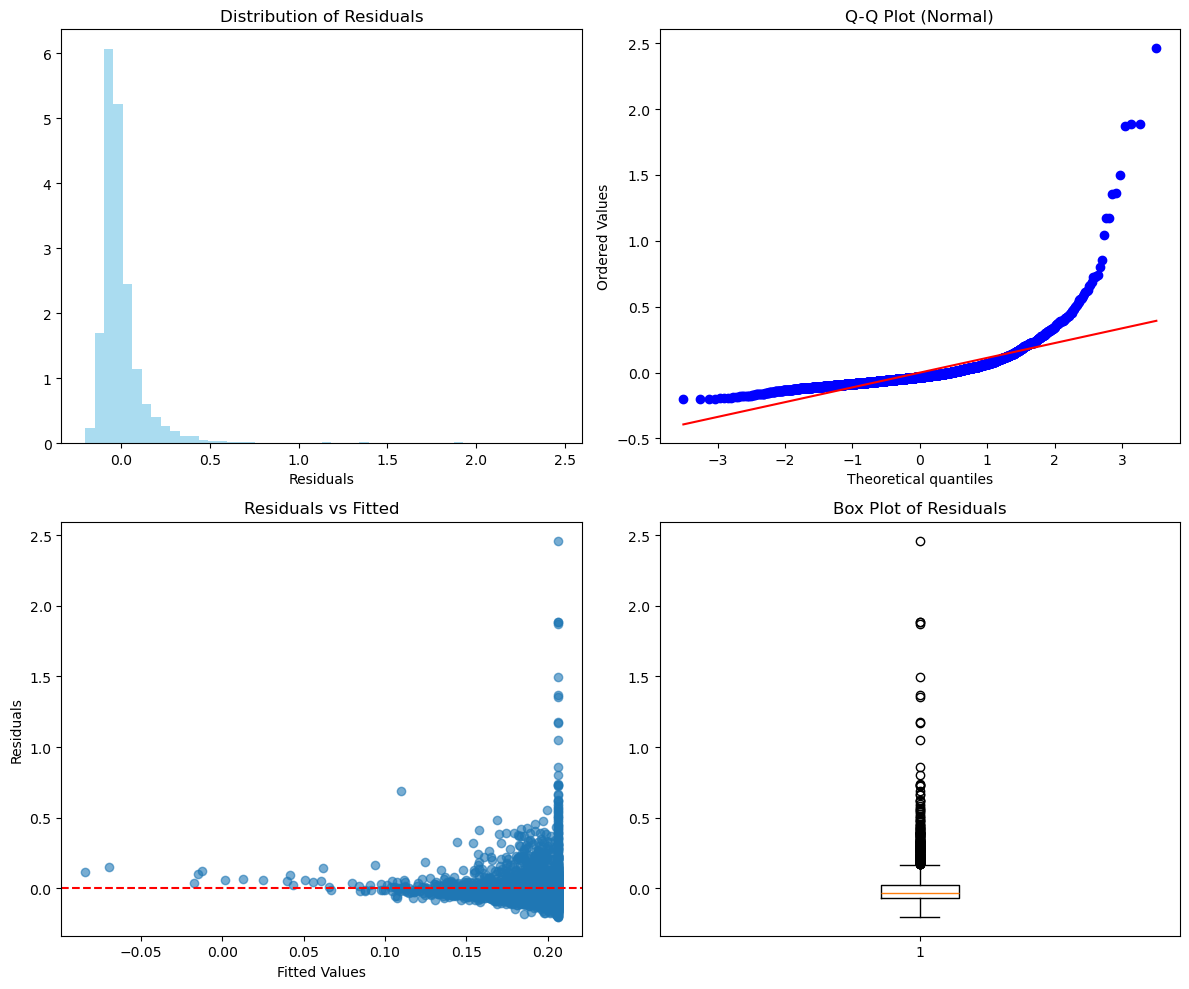

Evaluating bp_stat for: real_estate_and_rental_and_leasing_wage_share
bp_stat: 12.999929703314427 | bp_pvalue: 0.00031150267088145


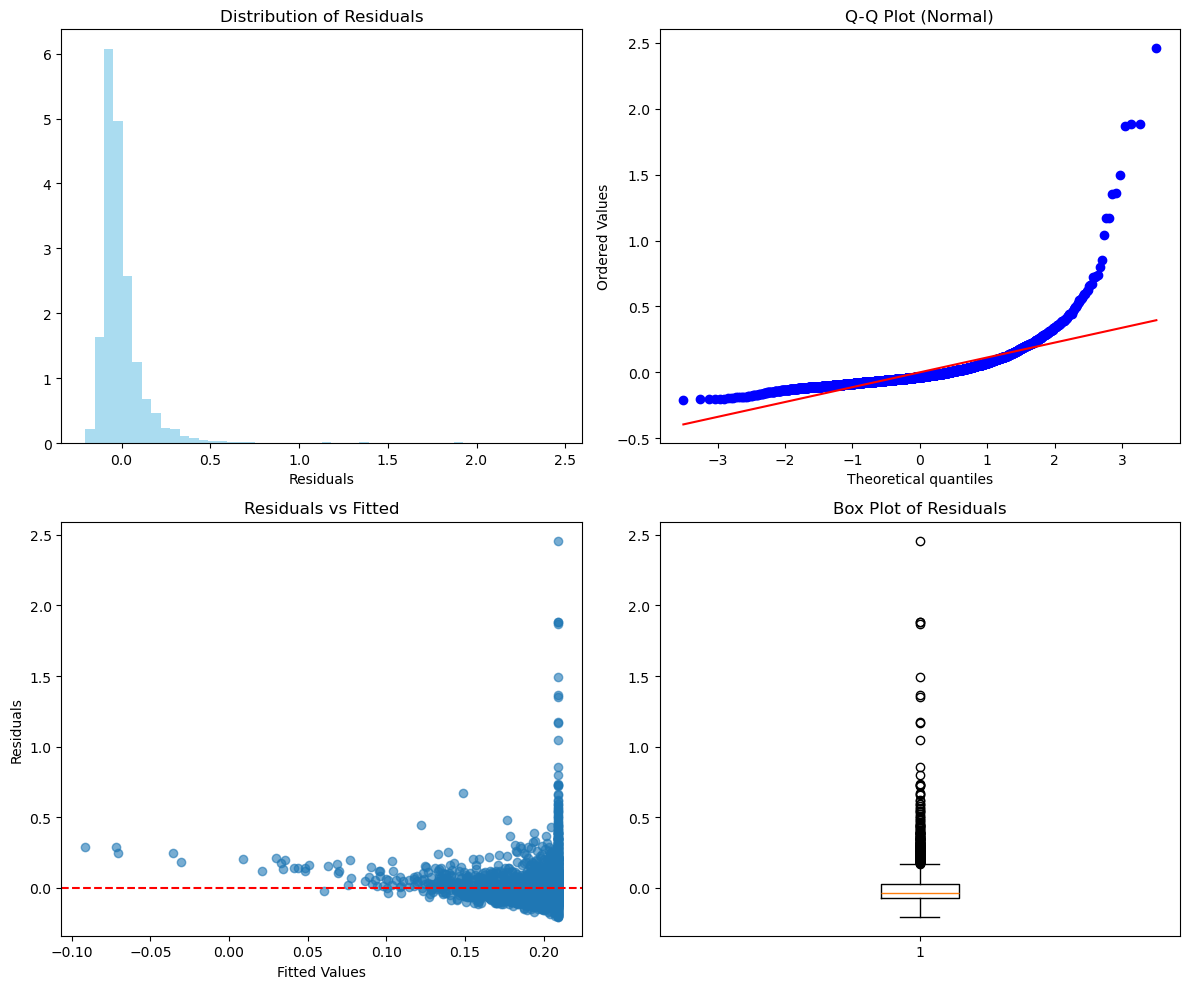

Evaluating bp_stat for: retail_trade_wage_share
bp_stat: 33.03881073190809 | bp_pvalue: 9.033744510774462e-09


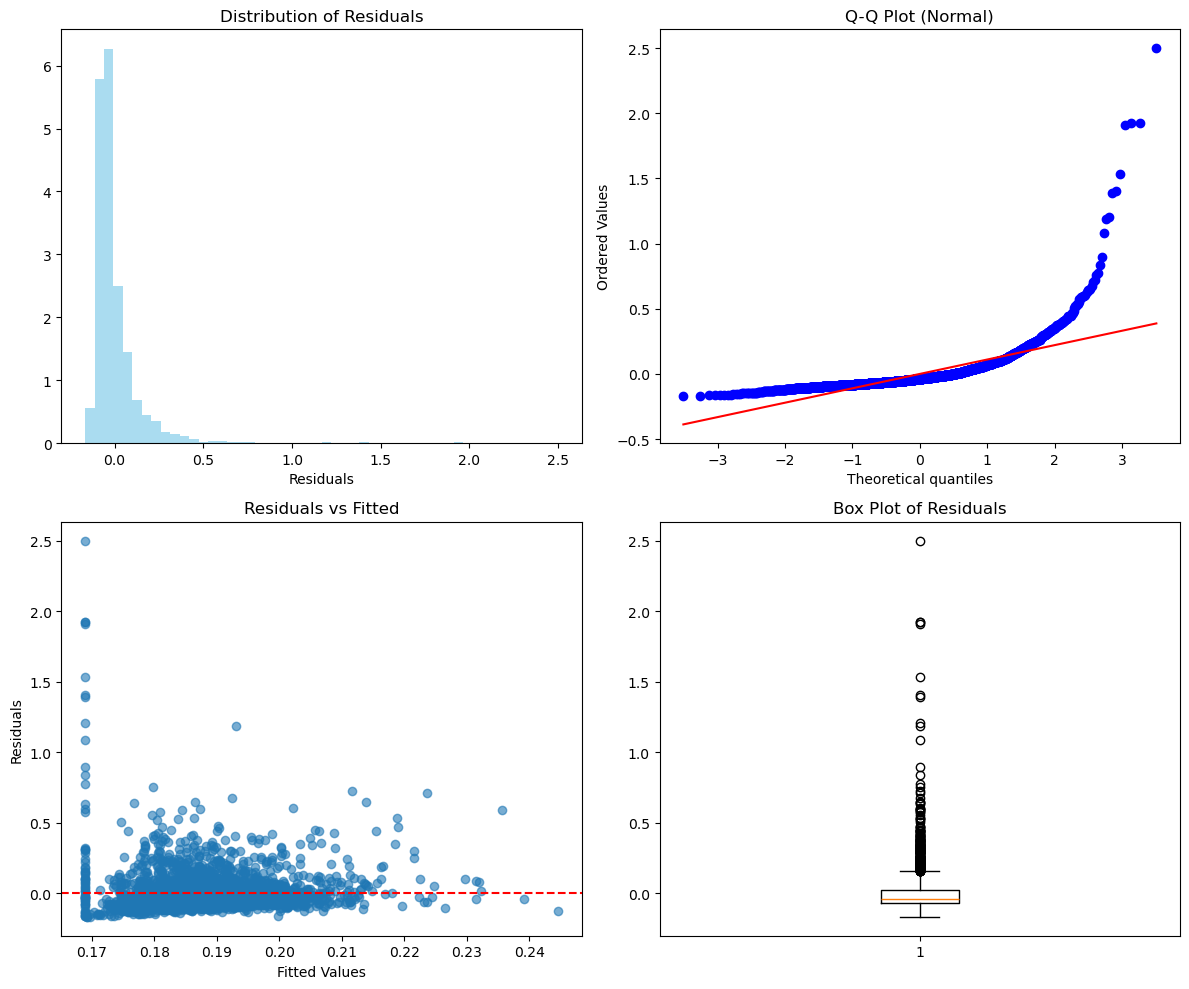

Evaluating bp_stat for: transportation_and_warehousing_wage_share
bp_stat: 4.46076470850852 | bp_pvalue: 0.03468196792371629


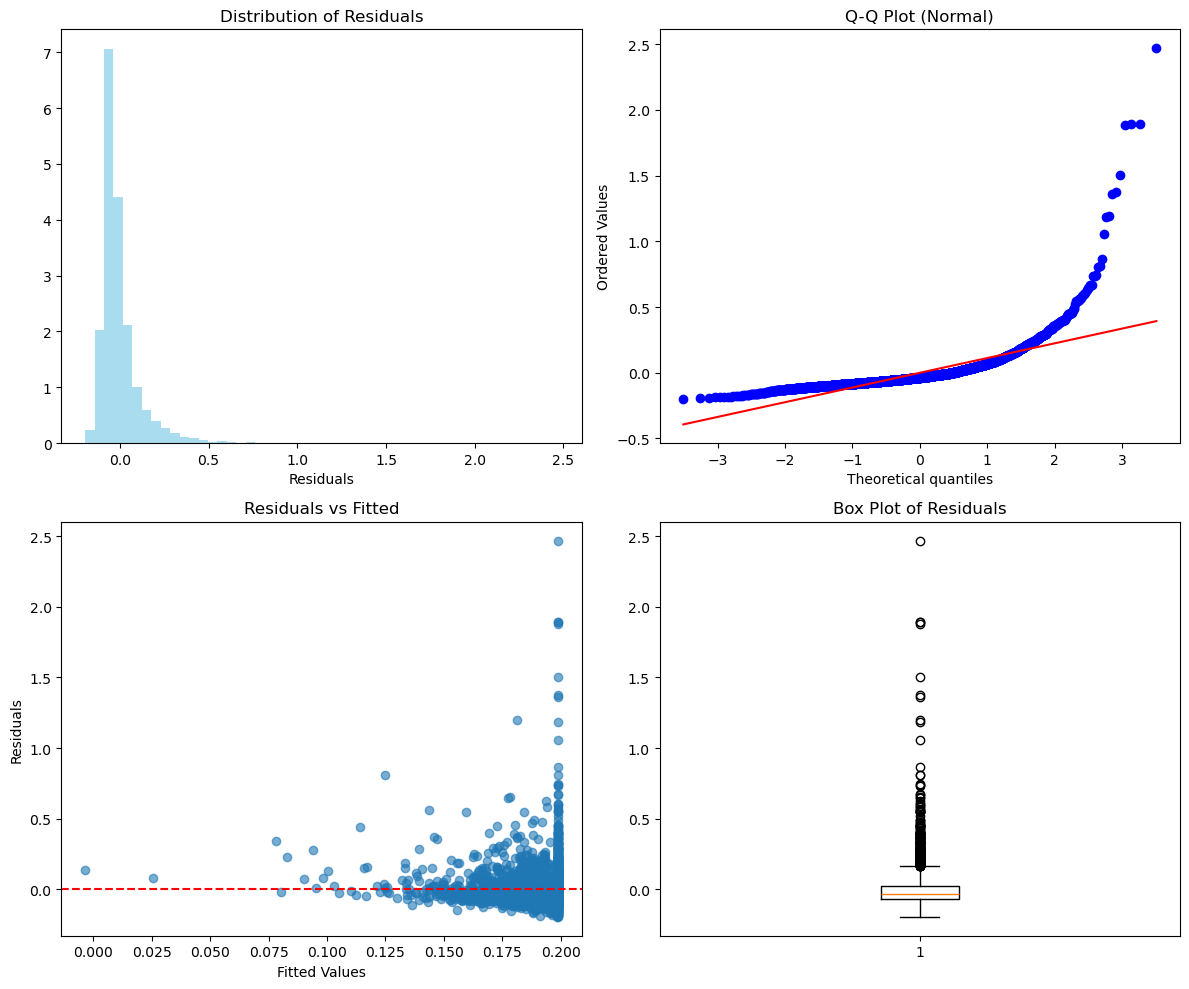

Evaluating bp_stat for: unclassified_wage_share
bp_stat: 0.258129907338424 | bp_pvalue: 0.611407854111415


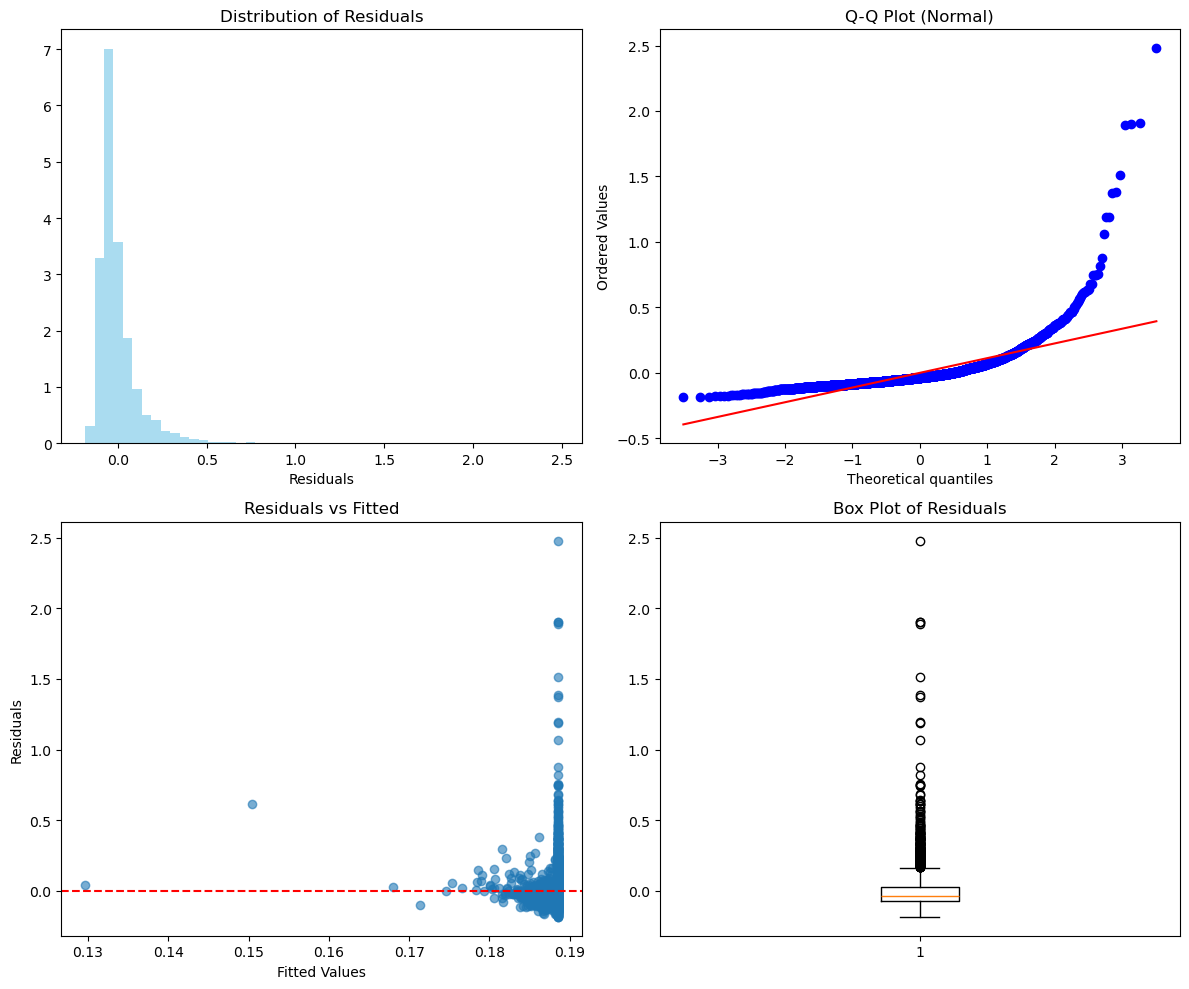

Evaluating bp_stat for: utilities_wage_share
bp_stat: 2.577465394875225 | bp_pvalue: 0.10839510338692533


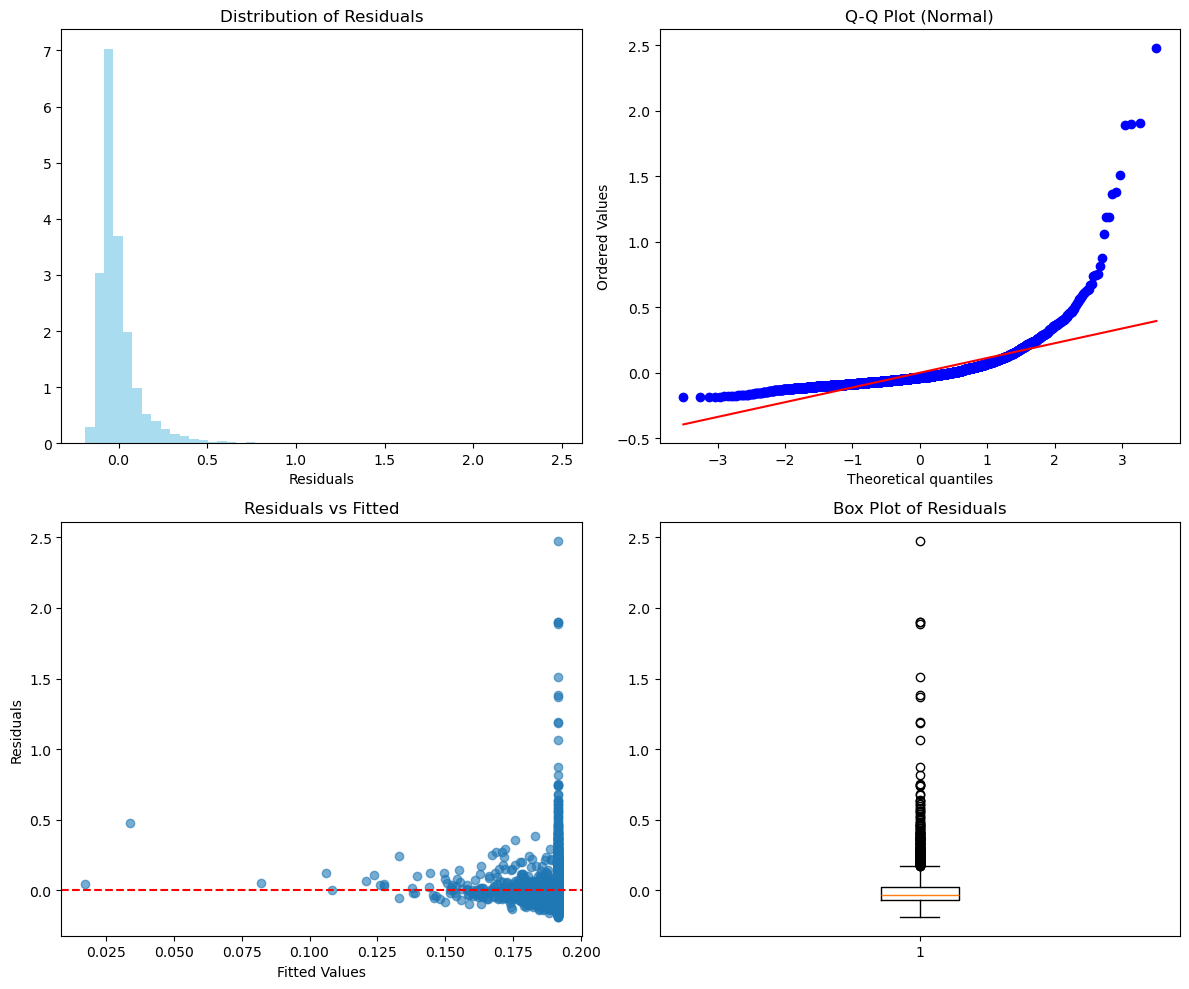

Evaluating bp_stat for: wholesale_trade_wage_share
bp_stat: 0.20362657262984607 | bp_pvalue: 0.6518093687636013


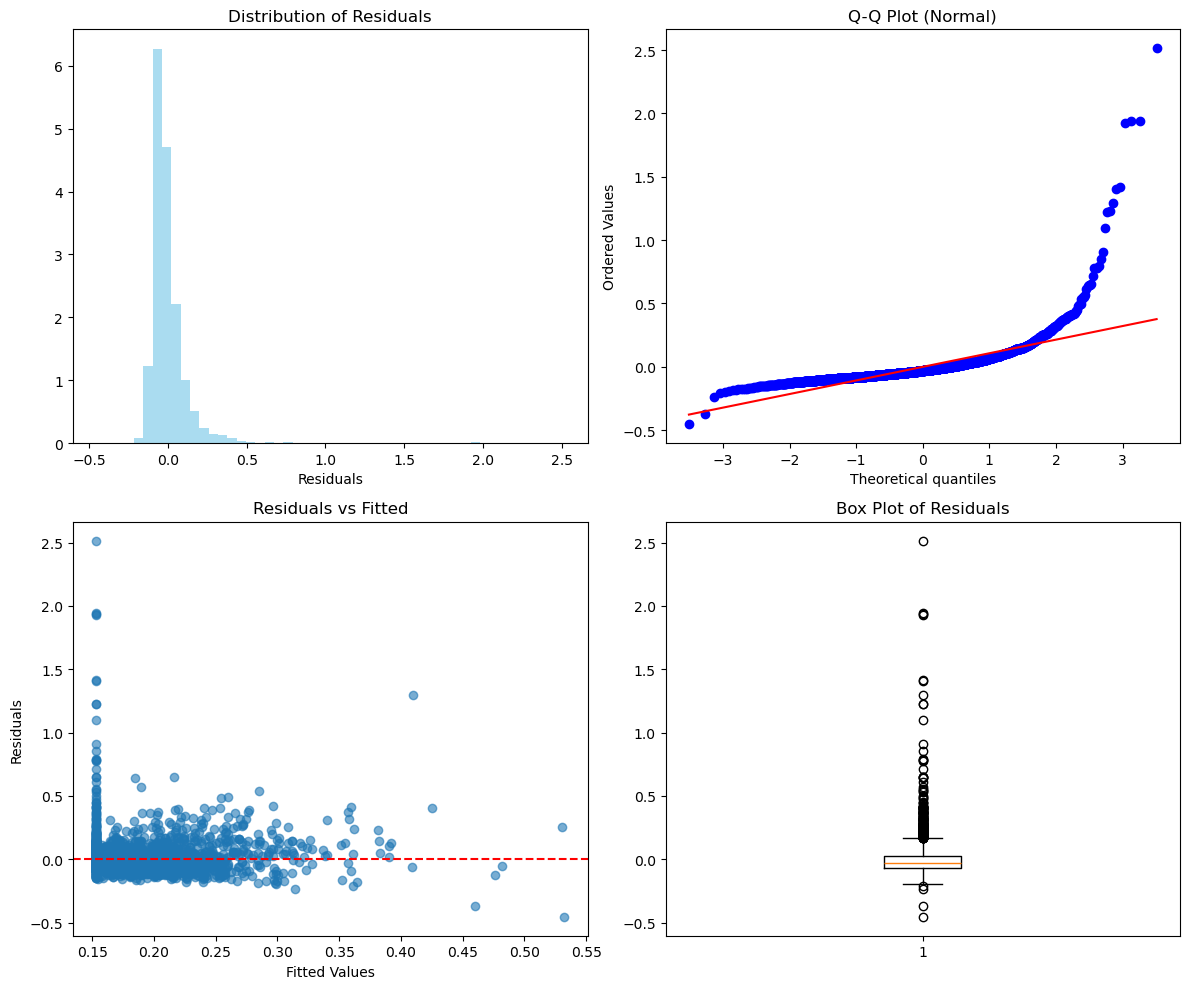

In [44]:
for var in no_loc_df.select_dtypes(include=[np.number]).columns:
    
    if var == target:
        continue
        
    print(f'Evaluating bp_stat for: {var}')
    het_model_spec = {
        'target': target,
        'transform': 'log',
        'data': no_loc_df,
        'exclusion_set': set(no_loc_df.columns) - {var}
        # 'cat_var_set': set(["C(urbanicity, Treatment(reference='urban'))"])
    }.copy()
    
    het_model_formula = me.generate_formula_string(**het_model_spec)
    het_model = smf.ols(het_model_formula, data=no_loc_df).fit(cov_type='HC3')
    
    me.test_model_assumptions(het_model)

## Test robust model

Makes heteroscedacity worse. Return to HC3 or transformations to approach more normal residuals. 

bp_stat: 1521.6722223992135 | bp_pvalue: 1.3025743051499262e-302


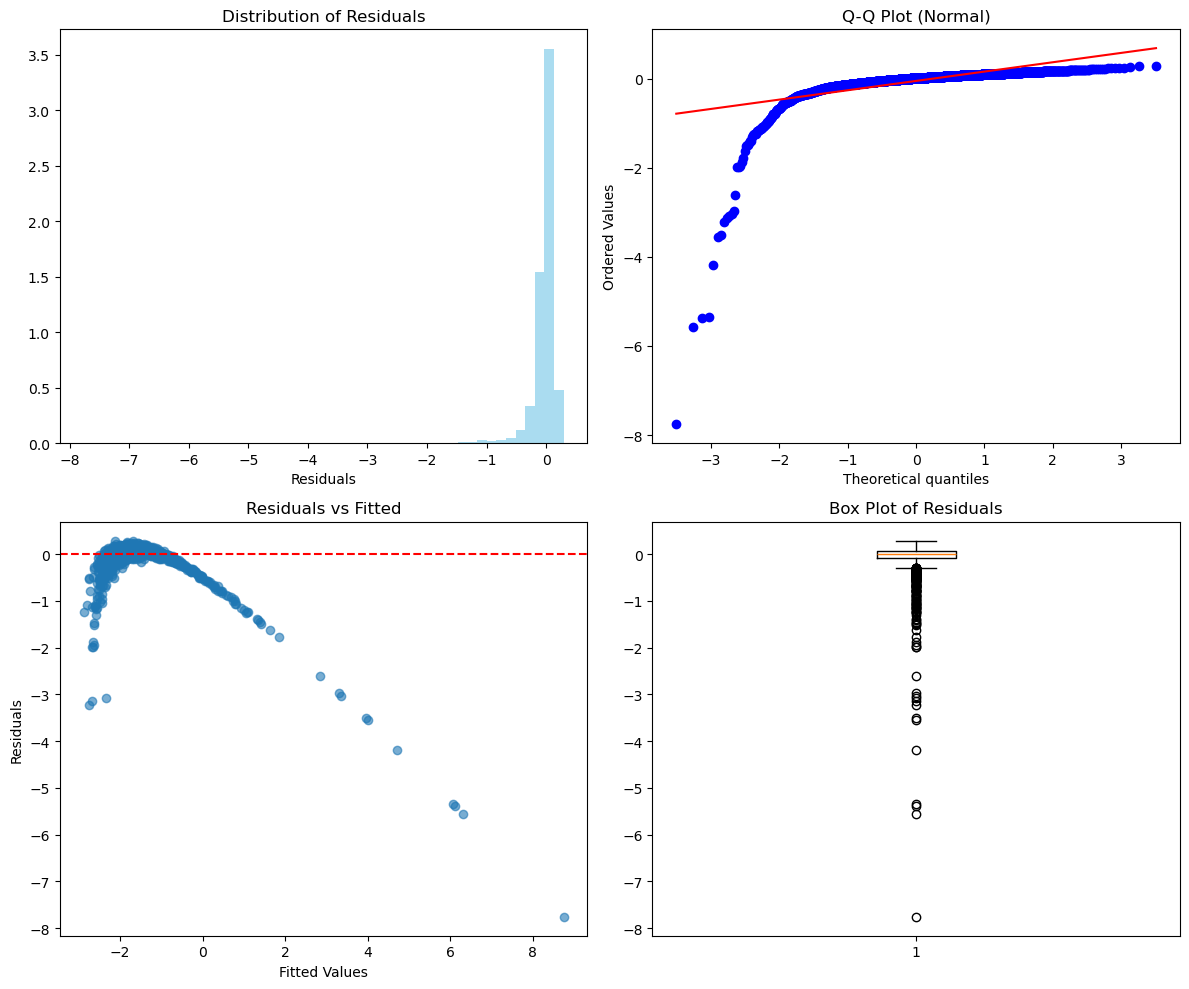

In [45]:
robust_model = smf.rlm(formula=m_col_formula, data=no_loc_df).fit()
robust_model.summary()
me.test_model_assumptions(robust_model)